### SINDy-SHRED trained on 1d -> 3d reconstructions of the high fidelity sim and used to infere on the outputs of DA-SHRED

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

SINDy-SHRED further extends the SHRED architecture by integrating **Sparse Identification of Nonlinear Dynamics (SINDy)** into the recurrent decoder framework. The key idea is to enforce a **parsimonious latent space representation**, where the dynamics of the latent variables are governed by a **sparse set of basis functions**.

More formally, SINDy-SHRED introduces an additional inductive bias:

$$\dot{z} = \Theta(z) \xi$$

where:

- $z = \mathcal{G} \left( \{ y_i \} _{i=t-k}^t \right)$ represents the **latent space variables** extracted by the LSTM encoder.
- $\Theta(z)$ is a **library of candidate nonlinear functions**.
- $\xi$ is a **sparse coefficient matrix** that determines the governing equations.

This combination enables **interpretable spatio-temporal modeling** by ensuring that the learned representations adhere to a **governing law**, making the method suitable for **data-driven discovery of dynamical systems** from high-dimensional, noisy observations.

In this notebook, we will walk through the application of **SINDy-SHRED** on the **weekly mean sea-surface temperature (SST) dataset**, demonstrating how the model can **learn a reduced-order latent representation** and **recover the governing equations** that describe the SST evolution.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [1]:
import torch
import random
import numpy as np

print("MPS built:", torch.backends.mps.is_built())
print("MPS available:", torch.backends.mps.is_available())

# If available:
device = torch.device("mps")
x = torch.ones(1, device=device)
print(x)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


MPS built: True
MPS available: True
tensor([1.], device='mps:0')


In [11]:
import math
np.math = math
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import sys


RDE_dataset = np.load(os.path.join("./high_fidelity_sim_data", "interpolated_combined.npy"))
grid_points = np.load(os.path.join("./high_fidelity_sim_data", "cylindrical_grid.npy"), allow_pickle=True).item()



import sindy
import sindy_shred
from processdata import load_data
from processdata import TimeSeriesDataset

from utils_preprocessing import (
    load_xy_grid,
    load_grid_dims,
    plot_spatial_modes_with_xy,
    plot_field_snapshot,
    create_field_animation,
    plot_histogram,
    straighten_data
)


import pysindy as ps
from pysindy.differentiation import FiniteDifference


num_sensors = 100
lags = 10
# load_X = load_data('SST')
load_X = RDE_dataset
n = load_X.shape[0]
m = load_X.shape[1]
print(" n = ", n, " m = ", m)
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

 n =  250  m =  30000


We now select indices to divide the data into training, validation, and test sets.

Set random seed

In [12]:
# project to 2d:
def project_in_the_r_direction(data, grid_points):
    """
    Project the 3D dataset into 2D by averaging over the radial direction.
    
    Parameters:
    - data: np.ndarray of shape (time, n_grid_points)
    - grid_points: dict with keys 'R_grid', 'Theta_grid', 'Z_grid'
    
    Returns:
    - projected_data: np.ndarray of shape (time, n_h, n_phi)
    - phi_grid: np.ndarray of shape (n_phi,)
    - h_grid: np.ndarray of shape (n_h,)
    """
    r_axis = grid_points['r_axis']
    phi_axis = grid_points['phi_axis']
    h_axis = grid_points['h_axis']
    
    n_time = data.shape[0]
    n_phi = phi_axis.shape[0]
    n_h = h_axis.shape[0]
    
    def cart2cyl(x, y, z):
        """Convert Cartesian coordinates to cylindrical coordinates."""
        r = np.sqrt(x**2 + z**2)
        phi = np.arctan2(z, x)
        h = y
        return r, phi, h    
        
    projected_data = np.zeros((n_time, n_h, n_phi))
    project_coords = cart2cyl(grid_points['X_grid'], grid_points['Y_grid'], grid_points['Z_grid'])

    for i_phi in range(n_phi):
        for i_h in range(n_h):
            # Find indices where phi and h match
            indices = np.where((grid_points['PHI_grid'] == phi_axis[i_phi]) & 
                               (grid_points['H_grid'] == h_axis[i_h]))[0]
            if len(indices) > 0:
                # Average over the radial direction
                projected_data[:, i_h, i_phi] = np.mean(data[:, indices], axis=1)
            else:
                projected_data[:, i_h, i_phi] = 0.0  # or np.nan, depending on preference
   
    return projected_data, phi_axis, h_axis



In [13]:
last_train_index = int(0.8 * (n - lags))
train_indices = np.arange(0, last_train_index)
mask = np.ones(n - lags)
print(" n  = ", n , " lags = ", lags)
print(" shape of mask: ", mask.shape)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
n_valid_test = valid_test_indices.shape[0]
valid_indices = valid_test_indices[:n_valid_test//2]
test_indices = valid_test_indices[n_valid_test//2:]
n_train = train_indices.shape[0]
n_valid = valid_indices.shape[0]
n_test = test_indices.shape[0]
print(" n_train = ", n_train, " n_valid = ", n_valid, " n_test = ", n_test)

 n  =  250  lags =  10
 shape of mask:  (240,)
 n_train =  192  n_valid =  24  n_test =  24


[debugging how to create the 1d dataset]
 
 x =  (10000,) 
 nx =  100 
 y =  (10000,) [end of debug]
 [inside create_1d_dataset] 
 n_timesteps  250
 RDE_dataset shape:  (250, 10000)
 y:  [2.07519531e-05 2.07519531e-05 2.07519531e-05 ... 7.49841309e-02
 7.49841309e-02 7.49841309e-02]
 Closest y value to target_y=0.02: 0.019708103989109858
 y shape:  (10000,)
 Number of y_indices found:  100
 dataset_1d shape:  (250, 100)


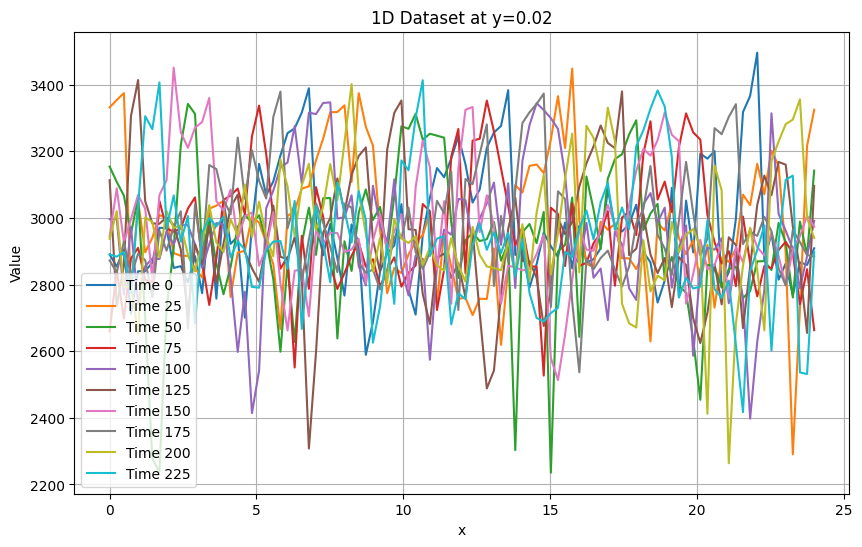

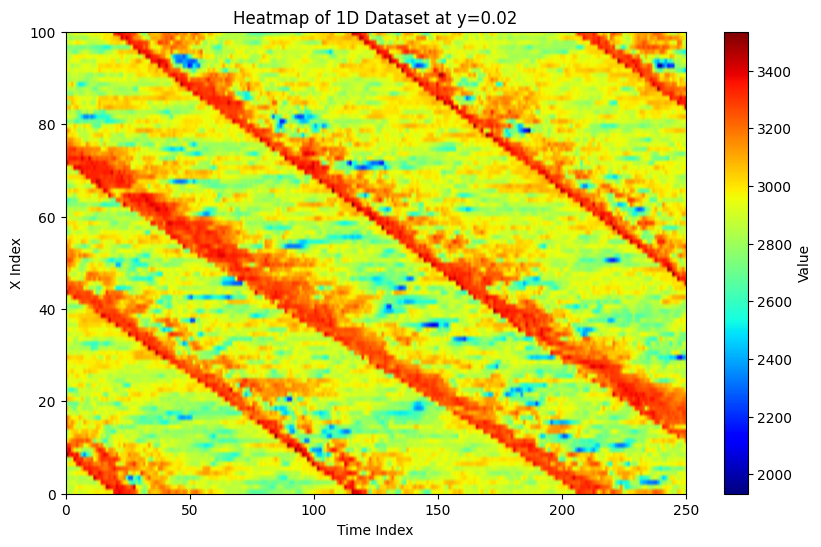

In [14]:
projected_data, phi_axis, h_axis = project_in_the_r_direction(RDE_dataset, grid_points)

nx=phi_axis.shape[0]
ny=h_axis.shape[0]
x_values = phi_axis
y_values = h_axis

def generate_grid_from_coordinate_vals(x_values, y_values, nx, ny):
    assert x_values.shape[0] == nx and y_values.shape[0] == ny,  "wrong shapes"
    
    # just repeat x vals ny times:
    # 1D flatten-style repeat: [1,2,3, 1,2,3, 1,2,3]
    x_coordinate_grid = np.tile(x_values, ny)
    # Each element repeated n times: [1,1,1, 2,2,2, 3,3,3]
    y_coordinate_grid = np.repeat(y_values, nx)
    return x_coordinate_grid, y_coordinate_grid
    
x, y = generate_grid_from_coordinate_vals(x_values, y_values,nx,ny)

def create_1d_dataset(RDE_dataset, nx, ny, x,y, target_y):
    """ 
        Create a 1D dataset by selecting data at a specific y value from the 2D dataset.
        Inputs:
            RDE_dataset: 2D array of shape (timesteps, nx*ny) or 3D array (timesteps, nx, ny)
            nx, ny: grid dimensions
            x, y: 1D arrays of x and y coordinates
        target_y: the y value at which to extract the 1D dataset
        Returns: 
            1D dataset of shape (timesteps, nx)
    """
    n_timesteps, n_spatial  = RDE_dataset.shape
    print(" [inside create_1d_dataset] ")
    print(" n_timesteps ", n_timesteps)
    print(" RDE_dataset shape: ", RDE_dataset.shape)
    print(" y: " , y)
    
    # Find the closest y value to target_y
    closest_y_idx = np.argmin(np.abs(y - target_y))
    
    print(f" Closest y value to target_y={target_y}: {y[closest_y_idx]}")
    print(" y shape: ", y.shape)
    y_indices = np.where(y == y[closest_y_idx])[0]
    
    print(" Number of y_indices found: ", len(y_indices))
    
    # select all timesteps at these y indices
    dataset_1d = RDE_dataset[:, y_indices]
    print(" dataset_1d shape: ", dataset_1d.shape)
    # verify shape is (timesteps, nx)
    assert dataset_1d.shape == (n_timesteps, nx), "Shape mismatch: expected (timesteps, nx)"
    return dataset_1d


def plot_1d_dataset(dataset1d, L, target_y):
    num_timesteps = dataset1d.shape[0]
    num_x_indices = dataset1d.shape[1]
    
    x = np.linspace(0, L, num_x_indices)
    plt.figure(figsize=(10, 6))
    for t in range(0, num_timesteps, max(1, num_timesteps // 10)):
        plt.plot(x, dataset1d[t, :], label=f'Time {t}')
    plt.title(f'1D Dataset at y={target_y}')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

t, nx, ny = projected_data.shape
projected_data_2d = projected_data.reshape(t, nx*ny)

print("[debugging how to create the 1d dataset]\n",
      "\n x = ", x.shape,
      "\n nx = ", nx,
      "\n y = ", y.shape,
      "[end of debug]")

dataset1d = create_1d_dataset(projected_data_2d, nx, ny, x, y, target_y=0.02)
n_timesteps, n_spatial  = RDE_dataset.shape
L = 24.0
plot_1d_dataset(dataset1d, L, target_y=0.02)

# plot the heatmap of the 1d dataset

def plot_1d_dataset_as_heatmap(dataset1d): 

    plt.figure(figsize=(10, 6))
    plt.imshow(dataset1d.T, aspect='auto', cmap='jet', extent=[0, dataset1d.shape[0], 0, dataset1d.shape[1]])
    plt.colorbar(label='Value')
    plt.xlabel('Time Index')
    plt.ylabel('X Index')
    plt.title('Heatmap of 1D Dataset at y=0.02')
    plt.show()
    
plot_1d_dataset_as_heatmap(dataset1d)

Projected data shape: (250, 100, 100)
 shape of raveled_data: (250, 10000)
 n =  250  m =  10000


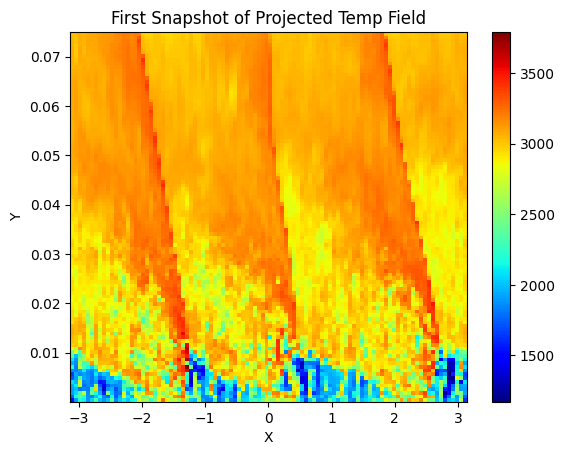

In [17]:
projected_data, phi_axis, h_axis = project_in_the_r_direction(RDE_dataset, grid_points)
print(f"Projected data shape: {projected_data.shape}")  # should be (time, n_h, n_phi)
# print(" shape of projected_data:", projected_data.shape)
raveled_data = projected_data.reshape(projected_data.shape[0], -1)
print(" shape of raveled_data:", raveled_data.shape)

plot_field_snapshot(
    raveled_data.T,
    time_index=0,
    nx=phi_axis.shape[0],
    ny=h_axis.shape[0],
    x=phi_axis,
    y=h_axis,
    title="First Snapshot of Projected Temp Field",
    cmap="jet",
)
load_X = raveled_data

num_sensors = 10
lags = 10

n = load_X.shape[0]
m = load_X.shape[1]
print(" n = ", n, " m = ", m)
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

Applying wave straightening with shift_per_row=-0.41
Shape after straightening: (250, 100, 100)
 shape of load_X_straightened: (250, 10000)


<Axes: title={'center': 'First Snapshot of Projected Temp Field'}, xlabel='X', ylabel='Y'>

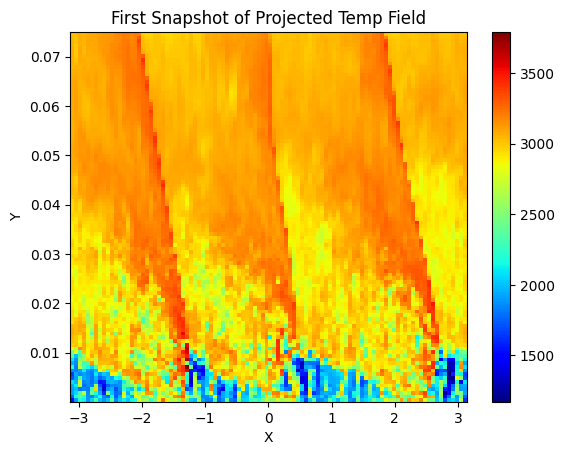

In [18]:
# now I cancel the rotation:

# Apply wave straightening (remove travelling wave rotation)
SHIFT_PER_ROW =  -0.41  # pixels per timestep - adjust as needed
print(f"Applying wave straightening with shift_per_row={SHIFT_PER_ROW}")
load_X_straightened = straighten_data(
    load_X, nx=100, ny=100, shift_per_row=SHIFT_PER_ROW
)
print("Shape after straightening:", load_X_straightened.shape)
load_X_straightened = load_X_straightened.reshape(load_X_straightened.shape[0], nx*ny)  # reshape to (time, n_h * n_phi)
print(" shape of load_X_straightened:", load_X_straightened.shape)
plot_field_snapshot(
    load_X_straightened.T,
    time_index=0,
    nx=phi_axis.shape[0],
    ny=h_axis.shape[0],
    x=phi_axis,
    y=h_axis,
    title="First Snapshot of Projected Temp Field",
    cmap="jet",
)


<Axes: title={'center': 'Last Snapshot of Projected Temp Field'}, xlabel='X', ylabel='Y'>

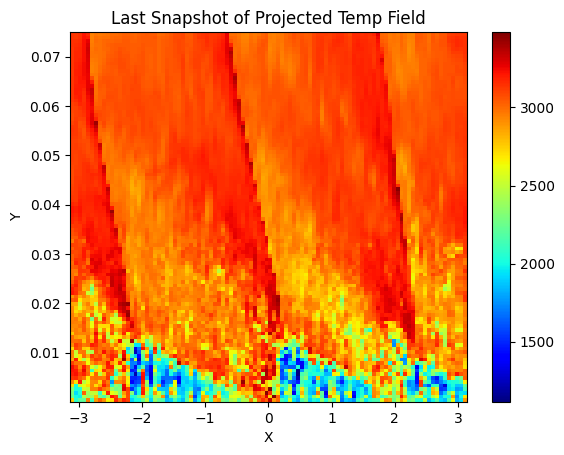

In [22]:
plot_field_snapshot(
    load_X_straightened.T,
    time_index=-1,
    nx=phi_axis.shape[0],
    ny=h_axis.shape[0],
    x=phi_axis,
    y=h_axis,
    title="Last Snapshot of Projected Temp Field",
    cmap="jet",
)

 [inside create_1d_dataset] 
 n_timesteps  250
 RDE_dataset shape:  (250, 10000)
 y:  [2.07519531e-05 2.07519531e-05 2.07519531e-05 ... 7.49841309e-02
 7.49841309e-02 7.49841309e-02]
 Closest y value to target_y=0.02: 0.019708103989109858
 y shape:  (10000,)
 Number of y_indices found:  100
 dataset_1d shape:  (250, 100)


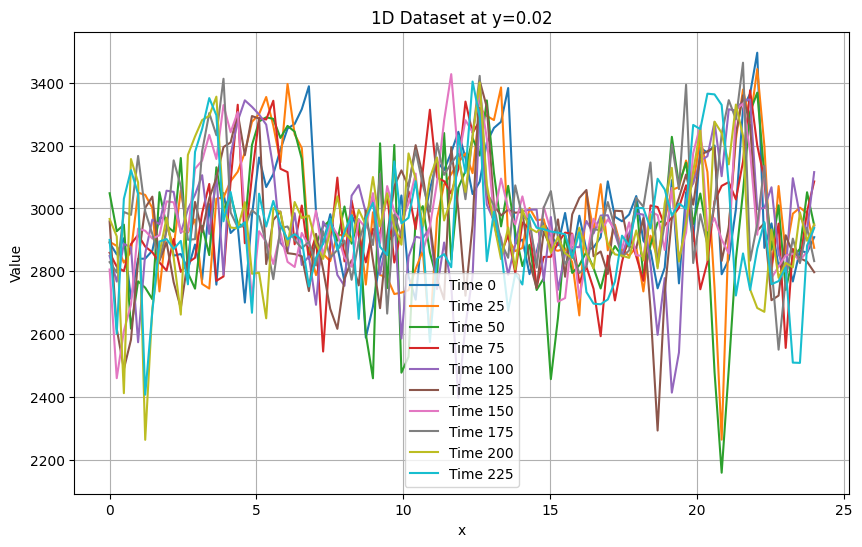

 shape of dataset1d_straight:  (250, 100)


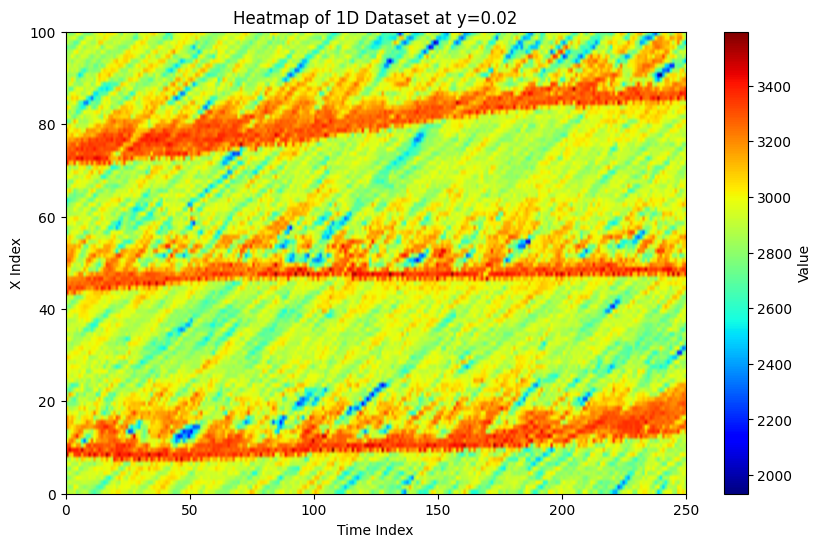

Saving 1D dataset to ../DA-SHRED_RDE/1d_RDE_SIM/1d_dataset_hard_dataset.npy
Shape of what we are saving:  (250, 100)


In [23]:
dataset1d_straight = create_1d_dataset(load_X_straightened, nx, ny, x, y, target_y=0.02)

plot_1d_dataset(dataset1d_straight, L, target_y=0.02)
print(" shape of dataset1d_straight: ", dataset1d_straight.shape)

plot_1d_dataset_as_heatmap(dataset1d_straight)

# saving -- this is the input for 1d -> 3D
print("Saving 1D dataset to ../DA-SHRED_RDE/1d_RDE_SIM/1d_dataset_hard_dataset.npy")
print("Shape of what we are saving: " , dataset1d_straight.shape)
# np.save("/1d_dataset_hard_dataset.npy", dataset1d_straight)
input_high_fidelity_1d_dataset = dataset1d_straight

In [24]:
last_train_index = int(0.8 * (n - lags))
train_indices = np.arange(0, last_train_index)
mask = np.ones(n - lags)
print(" n  = ", n , " lags = ", lags)
print(" shape of mask: ", mask.shape)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
n_valid_test = valid_test_indices.shape[0]
valid_indices = valid_test_indices[:n_valid_test//2]
test_indices = valid_test_indices[n_valid_test//2:]
n_train = train_indices.shape[0]
n_valid = valid_indices.shape[0]
n_test = test_indices.shape[0]
print(" n_train = ", n_train, " n_valid = ", n_valid, " n_test = ", n_test)

 n  =  250  lags =  10
 shape of mask:  (240,)
 n_train =  192  n_valid =  24  n_test =  24


Applying wave straightening with shift_per_row=-0.41
Shape after straightening: (250, 100, 100)
 shape of load_X_straightened: (250, 10000)


<Axes: title={'center': 'First Snapshot of Projected Temp Field'}, xlabel='X', ylabel='Y'>

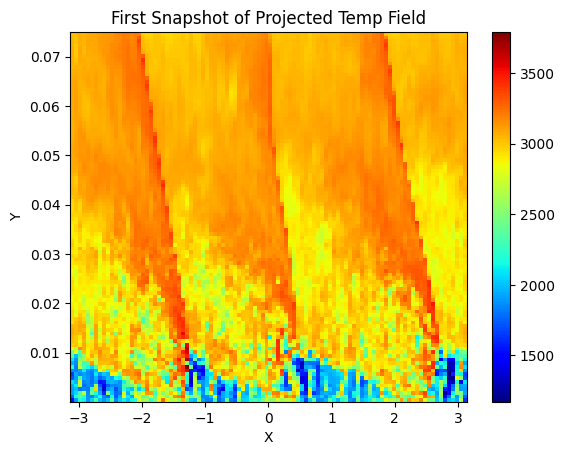

In [25]:
# now I cancel the rotation:

# Apply wave straightening (remove travelling wave rotation)
SHIFT_PER_ROW =  -0.41  # pixels per timestep - adjust as needed
print(f"Applying wave straightening with shift_per_row={SHIFT_PER_ROW}")
load_X_straightened = straighten_data(
    load_X, nx=100, ny=100, shift_per_row=SHIFT_PER_ROW
)
print("Shape after straightening:", load_X_straightened.shape)
load_X_straightened = load_X_straightened.reshape(load_X_straightened.shape[0], nx*ny)  # reshape to (time, n_h * n_phi)
print(" shape of load_X_straightened:", load_X_straightened.shape)
plot_field_snapshot(
    load_X_straightened.T,
    time_index=0,
    nx=phi_axis.shape[0],
    ny=h_axis.shape[0],
    x=phi_axis,
    y=h_axis,
    title="First Snapshot of Projected Temp Field",
    cmap="jet",
)


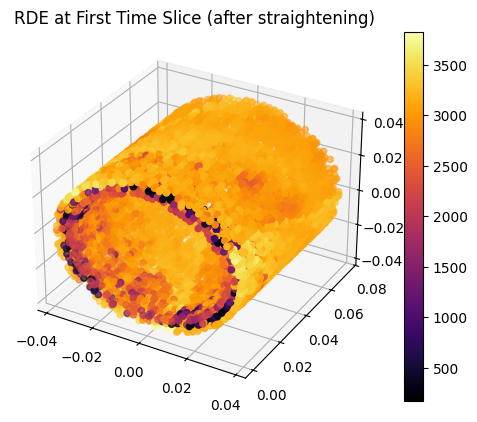

In [26]:
def plot_3d_scatter(X, Y, Z, field, title="3D Scatter Plot"):
    n_to_plot = min(10000, X.shape[0])  # limit number of points to plot for clarity
    # subsample randomly
    indices = np.random.choice(X.shape[0], n_to_plot, replace=False)
    X = X[indices]
    Y = Y[indices]
    Z = Z[indices]
    field = field[indices]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X, Y, Z, c=field, cmap='inferno')
    plt.colorbar(sc)
    ax.set_title(title)
    plt.show()


first_time_slice = RDE_dataset[0,: ]  # (n_grid_points,
plot_3d_scatter(grid_points['X_grid'], grid_points['Y_grid'], grid_points['Z_grid'], first_time_slice, title="RDE at First Time Slice (after straightening)")


In [27]:
last_train_index = int(0.8 * (n - lags))
train_indices = np.arange(0, last_train_index)
mask = np.ones(n - lags)
print(" n  = ", n , " lags = ", lags)
print(" shape of mask: ", mask.shape)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
n_valid_test = valid_test_indices.shape[0]
valid_indices = valid_test_indices[:n_valid_test//2]
test_indices = valid_test_indices[n_valid_test//2:]
n_train = train_indices.shape[0]
n_valid = valid_indices.shape[0]
n_test = test_indices.shape[0]
print(" n_train = ", n_train, " n_valid = ", n_valid, " n_test = ", n_test)

 n  =  250  lags =  10
 shape of mask:  (240,)
 n_train =  192  n_valid =  24  n_test =  24


sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets.

In [8]:
class MinMax_scaler_custom:
    def __init__(self):
        self.min = None
        self.max = None 
    def fit(self, data):
        self.min = np.min(data,axis=0, keepdims=True)
        self.max = np.max(data,axis=0, keepdims=True)
        # print(" shape of min in scaler: ", self.min.shape)
    def transform(self, data):
        return (data - self.min) / (self.max - self.min + 1e-8)
    def inverse_transform(self, data):
        return data * (self.max - self.min + 1e-8) + self.min
    
    
class Gaussian_smoorther:
    def __init__(self, sigma_temporal=1.0, sigma_spatial = 1.0):
        self.sigma_temporal = sigma_temporal 
        self.sigma_spatial = sigma_spatial

    def smooth(self, data):
        from scipy.ndimage import gaussian_filter1d
        smoothed_data = gaussian_filter1d(data, sigma=self.sigma_temporal, axis=0)  
        smoothed_data = gaussian_filter1d(smoothed_data, sigma=self.sigma_spatial, axis=1)
        return smoothed_data
    

In [ ]:
# sc = MinMaxScaler()
# sc = sc.fit(load_X[train_indices])
# print("shape of load_X on which we fit the scaler:", load_X[train_indices].shape)

G_smoother = Gaussian_smoorther(sigma_temporal=.05, sigma_spatial=.5)
transformed_X = G_smoother.smooth(load_X)

sc = MinMax_scaler_custom()
sc.fit(transformed_X[train_indices])
print(" shape of load_X on which we fit the scaler:", transformed_X[train_indices].shape)  

transformed_X = sc.transform(transformed_X) # sc.transform(load_X)


### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = torch.device("mps") if torch.backends.mps.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

print("Training data shape:", train_data_in.shape, " on device:", train_data_in.device)
print("Validation data shape:", valid_data_in.shape, " on device:", valid_data_in.device)
print("Test data shape:", test_data_in.shape, " on device:", test_data_in.device)
   
### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

 shape of load_X on which we fit the scaler: (192, 30000)
Training data shape: torch.Size([192, 10, 1000])  on device: mps:0
Validation data shape: torch.Size([24, 10, 1000])  on device: mps:0
Test data shape: torch.Size([24, 10, 1000])  on device: mps:0


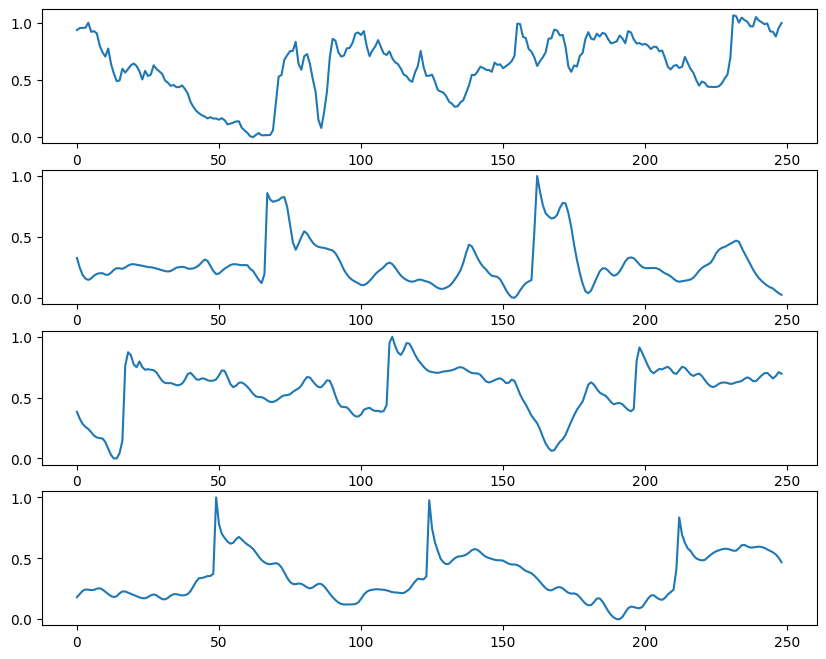

In [10]:
sub_index_X = transformed_X[:,sensor_locations] # this is the entire time series at sensor locations
n_to_plot = 4
fig, ax = plt.subplots(n_to_plot, figsize=(10, n_to_plot * 2))

for i in range(n_to_plot):
    ax[i].plot(sub_index_X[:-1,i])

We set up SINDy library coefficients

In [11]:
dt = 0.15 #4.75924829840751e-08 # 0.05 
hidden_layers = 10
latent_dim = 2 # 2
dropout = 0.4
poly_order = 3 # use 3 !
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)

l1 = 350
l2 = 600
lr = 2e-3
batch_size = 128
num_epochs = 500 #800
threshold = 0.005
sindy_regularization = 2 #10
mean_zero_regularization = 0.1
variance_regularization = 0.1

shred = sindy_shred.SINDy_SHRED(num_sensors, m, hidden_size=latent_dim, hidden_layers=hidden_layers, l1=l1, l2=l2, dropout=dropout,
                                 library_dim=library_dim, poly_order=poly_order,
                                include_sine=include_sine, dt=dt, device=device).to(device)

# Ensure model is on the correct device before training
shred = shred.to(device)

In [12]:
shred.train()
validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=batch_size, num_epochs=num_epochs,
                                    lr=lr, verbose=True, threshold=threshold, patience=5, sindy_regularization=sindy_regularization,
                                    mean_zero_regularization = mean_zero_regularization, variance_regularization=variance_regularization,
                                    optimizer="AdamW", thres_epoch=100)

# Rate of sparsity
# Make sure the rate of sparsity is over 0.2!!
print(" sindy sparsity coefficient: ", torch.mean(shred.e_sindy.coefficient_mask*1.0))
# on the SST dataset we are able to get this to 0.05 -- should achieve similar on RDE before forecasting!

test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(" REL ERRN TEST DATA: ", np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

# save model weights of the trained shred model:
torch.save(shred.state_dict(), "../sindy_shred_rde_model_weights.pth"); print(" Model weights saved. ")

W0105 10:15:50.023000 25428 torch/_inductor/utils.py:1613] [1/0] Not enough SMs to use max_autotune_gemm mode


1 : tensor(0.2764, device='mps:0', grad_fn=<AddBackward0>)
2 : tensor(0.1194, device='mps:0', grad_fn=<AddBackward0>)
3 : tensor(0.1300, device='mps:0', grad_fn=<AddBackward0>)
4 : tensor(0.0922, device='mps:0', grad_fn=<AddBackward0>)
5 : tensor(0.1109, device='mps:0', grad_fn=<AddBackward0>)
6 : tensor(0.0855, device='mps:0', grad_fn=<AddBackward0>)
7 : tensor(0.0959, device='mps:0', grad_fn=<AddBackward0>)
8 : tensor(0.0795, device='mps:0', grad_fn=<AddBackward0>)
9 : tensor(0.0715, device='mps:0', grad_fn=<AddBackward0>)
10 : tensor(0.0740, device='mps:0', grad_fn=<AddBackward0>)
11 : tensor(0.0697, device='mps:0', grad_fn=<AddBackward0>)
12 : tensor(0.0708, device='mps:0', grad_fn=<AddBackward0>)
13 : tensor(0.0696, device='mps:0', grad_fn=<AddBackward0>)
14 : tensor(0.0658, device='mps:0', grad_fn=<AddBackward0>)
15 : tensor(0.0667, device='mps:0', grad_fn=<AddBackward0>)
16 : tensor(0.0641, device='mps:0', grad_fn=<AddBackward0>)
17 : tensor(0.0659, device='mps:0', grad_fn=<AddB

KeyboardInterrupt: 

We then generate reconstructions from the test set and print mean square error compared to the ground truth.

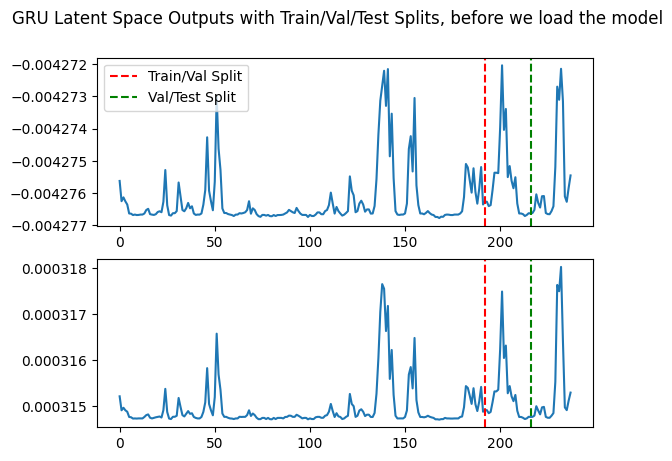

In [20]:

shred.eval()
# here we should plot the train, val and test GRU outputs to make sure there arent any discontinuities
all_dataset = torch.cat((train_dataset.X, valid_dataset.X, test_dataset.X), dim=0)

gru_outs, sindy_outs = shred.gru_outputs(all_dataset, sindy=True)
# differentiation_method = FiniteDifference()


fig, ax = plt.subplots(latent_dim)
# addd title: 
fig.suptitle('GRU Latent Space Outputs with Train/Val/Test Splits, before we load the model')
for i in range(latent_dim):
    ax[i].plot(gru_outs[1:,0,i].detach().cpu().numpy())
    # add vertical lines to indicate train/val/test splits
    ax[i].axvline(x=n_train, color='r', linestyle='--', label='Train/Val Split')
    ax[i].axvline(x=n_train + n_valid, color='g', linestyle='--', label='Val/Test Split')
ax[0].legend()

### Model discovery with SINDy

The following code block extracts latent states using a GRU model. Each of the first three dimensions is normalized and re-scaled to [-1,1]. A SINDy model is then set up with a polynomial library. This SINDy model is fitted to the data and later used to simulate the dynamics for comparison with the original GRU latent trajectories.

The hyperparameters for the SINDy model are set as follows:
- **Differentiation Method:** Finite difference is used to compute numerical derivatives. When the latent states trajectories are noisy, one should consider to use ps.differentiation.SmoothedFiniteDifference().
- **Optimizer Sequantially thresholded least-squares: STLSQ:**  
  - *Threshold:* 0.8, which controls the sparsity level by eliminating coefficients below this value.
  - *Alpha:* 0.05, L2 regularization.
- **Optimizer Mixed-interger optimization: MIOSR:**  
  - *group_sparsity:* how many termseach equations should include.
- **Feature Library:** Here we only include polynomial features up to degree 1, ensuring only linear terms are considered in the model. Practically this could set up to degree 3 which will include more nonlinear terms.

For model selection, a simple baseline standard is to visually examine how the long-term extrapolation behaves. We can pick the model that fits the data well. It is also possible to include metrics (like the MSE) to quantitatively measure these quantities.

In [21]:
# load the model weights (if the kernel crashed this saves us some time)
shred.load_state_dict(torch.load("../sindy_shred_rde_model_weights.pth"))

shred.eval()

SINDy_SHRED(
  (gru): GRU(1000, 2, num_layers=10, batch_first=True)
  (e_sindy): E_SINDy()
  (linear1): Linear(in_features=2, out_features=350, bias=True)
  (linear2): Linear(in_features=350, out_features=600, bias=True)
  (linear3): Linear(in_features=600, out_features=30000, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (layer_norm): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)

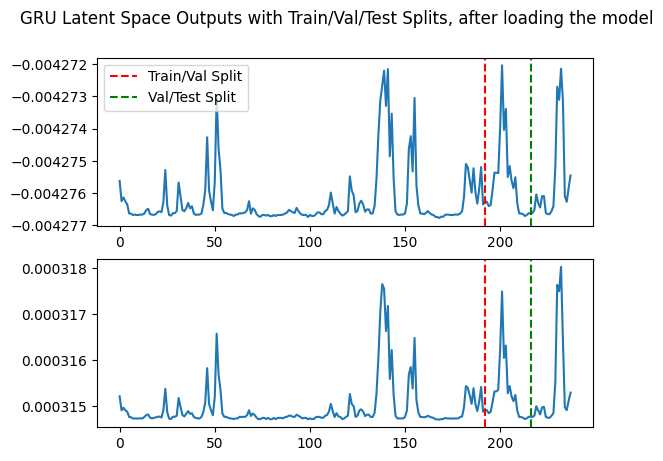

In [22]:

# here we should plot the train, val and test GRU outputs to make sure there arent any discontinuities
all_dataset = torch.cat((train_dataset.X, valid_dataset.X, test_dataset.X), dim=0)
gru_outs, sindy_outs = shred.gru_outputs(all_dataset, sindy=True)
differentiation_method = FiniteDifference()

fig, ax = plt.subplots(latent_dim)
fig.suptitle('GRU Latent Space Outputs with Train/Val/Test Splits, after loading the model')
for i in range(latent_dim):
    ax[i].plot(gru_outs[1:,0,i].detach().cpu().numpy())
    # add vertical lines to indicate train/val/test splits
    ax[i].axvline(x=n_train, color='r', linestyle='--', label='Train/Val Split')
    ax[i].axvline(x=n_train + n_valid, color='g', linestyle='--', label='Val/Test Split')
ax[0].legend()

 shape of gru_outs_numpy:  (239, 5, 2)
 dt for differentiation:  0.1
 shape of gru_outs_deriv:  (239, 5, 2)
 shape of gru_outs_double_deriv:  (239, 5, 2)


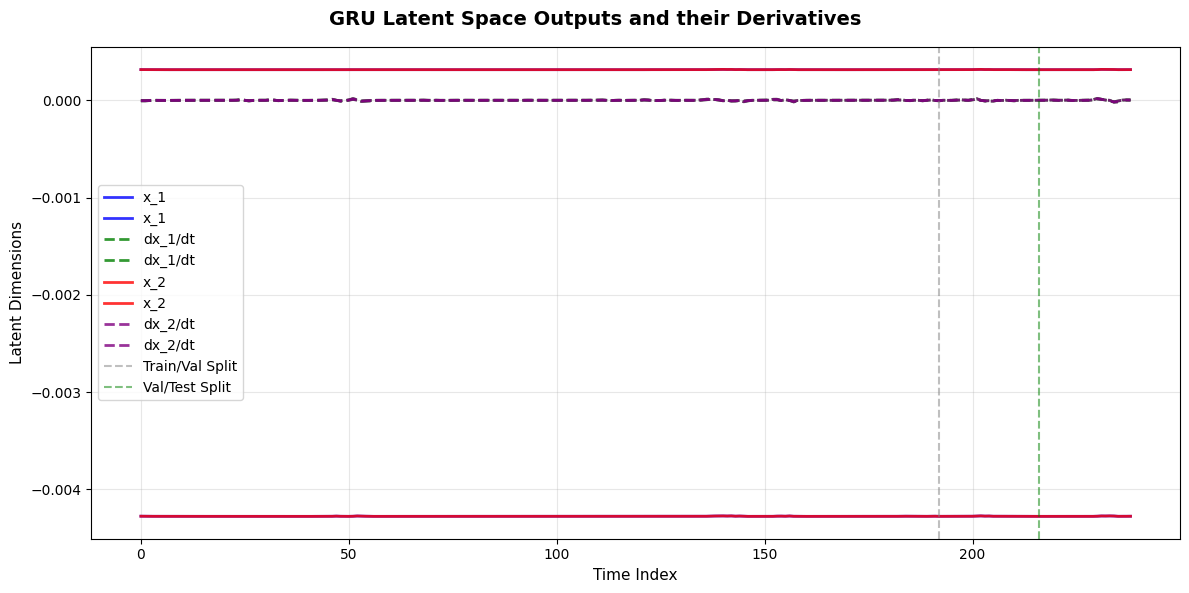

In [23]:
# compute the first derivative of the gru outputs using finite difference
gru_outs_numpy = gru_outs.detach().cpu().numpy()

print(" shape of gru_outs_numpy: ", gru_outs_numpy.shape)

# differentiation_method = ps.differentiation.SmoothedFiniteDifference(smoother_kws={'window_length': 10})
differentiation_method = ps.differentiation.FiniteDifference()
# compute x dot:
dt_for_differentiation = 0.1  # time step used during training
print(" dt for differentiation: ", dt_for_differentiation)
gru_outs_deriv = differentiation_method._differentiate(gru_outs_numpy, dt_for_differentiation)
print(" shape of gru_outs_deriv: ", gru_outs_deriv.shape)
gru_outs_double_deriv = differentiation_method._differentiate(gru_outs_deriv, dt_for_differentiation)
print(" shape of gru_outs_double_deriv: ", gru_outs_double_deriv.shape)

# plot x and x dot on a single plot for all latent dimensions
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle('GRU Latent Space Outputs and their Derivatives', fontsize=14, fontweight='bold')

colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

for i in range(latent_dim):
    # Plot x for each dimension
    ax.plot(gru_outs_numpy[:, i], linewidth=2, alpha=0.8, color=colors[i % len(colors)], label=f'x_{i+1}')
    # Plot dx/dt for each dimension
    ax.plot(gru_outs_deriv[:, i], linewidth=2, alpha=0.8, color=colors[(i + latent_dim) % len(colors)], linestyle='--', label=f'dx_{i+1}/dt')

ax.set_ylabel('Latent Dimensions', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axvline(x=n_train, color='gray', linestyle='--', alpha=0.5, label='Train/Val Split')
ax.axvline(x=n_train + n_valid, color='green', linestyle='--', alpha=0.5, label='Val/Test Split')
ax.legend(loc='best', fontsize=10)
ax.set_xlabel('Time Index', fontsize=11)

plt.tight_layout()
plt.show()

In [24]:
from pysindy.optimizers import MIOSR

gru_outs, sindy_outs = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs = gru_outs[:,0,:]

poly_order = 3
threshold = 0.001
alpha_for_sindy = 2
dt_for_sindy = .2

###############Normalization###############

for i in range(latent_dim):
    print(" GRU OUTS STATS BEFORE NORMALIZATION dim ", i, " min: ", torch.min(gru_outs[:,i]), " max: ", torch.max(gru_outs[:,i]))
    gru_outs[:,i] = (gru_outs[:,i] - torch.min(gru_outs[:,i])) / (torch.max(gru_outs[:,i])-torch.min(gru_outs[:,i]))

gru_outs = 2 * gru_outs - 1

###############SINDy discovery###############

x = gru_outs.detach().cpu().numpy()

# differentiation_method = ps.differentiation.SmoothedFiniteDifference()
# compute x dot:

print(" using dt for differentiation: ", dt_for_sindy)
x_deriv = differentiation_method._differentiate(x, dt_for_sindy)
print(" x shape: ", x.shape,
      " x_deriv shape: ", x_deriv.shape)

x_second_order_ODE = np.concatenate((x, x_deriv), axis=1)
print(" shape of x_second_order_ODE: ", x_second_order_ODE.shape)

differentiation_method = ps.differentiation.FiniteDifference()
# differentiation_method = ps.differentiation.SmoothedFiniteDifference(smoother_kws={'window_length': 9})

# model = ps.SINDy(
#     optimizer=ps.STLSQ(threshold=threshold, alpha=alpha_for_sindy),
#     differentiation_method=differentiation_method,
#     feature_library=ps.PolynomialLibrary(degree=poly_order)
# )

model = ps.SINDy(
    optimizer=MIOSR(group_sparsity=(2,2,2,4,5,5), alpha=5000),
    differentiation_method=differentiation_method,
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)


t_points = np.arange(0, len(x)) * (dt_for_sindy)

# model.fit(x, t=t_points)
# model.print()

model.fit(x_second_order_ODE, t=t_points)
model.print()


###############Plot the discovered SINDy model###############

t_train = np.arange(0, len(gru_outs)) * dt_for_sindy
# init_cond = np.zeros(latent_dim)
# init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
# x_sim = model.simulate(init_cond, t_train)

init_cond = np.zeros(2*latent_dim)
init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
init_cond[latent_dim:] = (differentiation_method._differentiate(gru_outs.detach().cpu().numpy(), dt_for_sindy))[0,:]
x_sim = model.simulate(init_cond, t_train)

fig, ax = plt.subplots(2*latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[:,i].detach().cpu().numpy())
    ax[i].plot(x_sim[:,i], "k--", label="model")
    ax[i].legend()
    
# plot also the derivatives
for i in range(latent_dim):
    ax[i + latent_dim].plot((differentiation_method._differentiate(gru_outs.detach().cpu().numpy(), dt_for_sindy))[:,i], label="gru_outs_deriv")
    ax[i + latent_dim].plot(x_sim[:,i + latent_dim], "k--", label="model deriv")
    ax[i + latent_dim].legend()

ImportError: cannot import name 'MIOSR' from 'pysindy.optimizers' (/Users/jaybu/Documents/RDE-DA-SHRED/.venv311/lib/python3.11/site-packages/pysindy/optimizers/__init__.py)

##### Reload data from the entire training set

In [ ]:
gru_outs_train, _ = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs_train = gru_outs_train[:,0,:]
gru_outs_val, _ = shred.gru_outputs(valid_dataset.X, sindy=True)
gru_outs_val = gru_outs_val[:,0,:]
gru_outs_test, _ = shred.gru_outputs(test_dataset.X, sindy=True)
gru_outs_test = gru_outs_test[:,0,:]

gru_outs_all = np.zeros((n_train + n_valid + n_test - 3, latent_dim))
gru_outs_all[:n_train-1,:] = gru_outs_train.detach().cpu().numpy()
gru_outs_all[n_train-1:n_train+n_valid-2,:] = gru_outs_val.detach().cpu().numpy()
gru_outs_all[n_train+n_valid-2:,:] = gru_outs_test.detach().cpu().numpy()

gru_outs_numpy = gru_outs_train.detach().cpu().numpy()

for i in range(latent_dim):
    print(" GRU OUTS ALL STATS BEFORE NORMALIZATION dim ", i, " min: ", np.min(gru_outs_all[:,i]), " max: ", np.max(gru_outs_all[:,i]))
    gru_outs_all[:,i] = (gru_outs_all[:,i] - np.min(gru_outs_numpy[:,i])) / (np.max(gru_outs_numpy[:,i])-np.min(gru_outs_numpy[:,i]))

gru_outs_all = 2 * gru_outs_all - 1

 GRU OUTS ALL STATS BEFORE NORMALIZATION dim  0  min:  -0.005449393764138222  max:  -0.005448419600725174
 GRU OUTS ALL STATS BEFORE NORMALIZATION dim  1  min:  -6.906967610120773e-05  max:  -6.877281703054905e-05


In [ ]:
def error_on_val(shred, dataset_to_compare, dt_for_sindy, sc):
    
    shred.eval()
    n_to_compare = len(dataset_to_compare)
    
    gru_outs_compare, _ = shred.gru_outputs(dataset_to_compare.X, sindy=True)
    gru_outs_compare = gru_outs_compare[:,0,:]
    gru_outs_compare_np = gru_outs_compare.detach().cpu().numpy()
    
    # Normalize the GRU outputs to [-1, 1] range, same as in model discovery
    # Use the training data min/max for consistent normalization
    for i in range(latent_dim):
        gru_outs_compare_np[:, i] = (gru_outs_compare_np[:, i] - np.min(gru_outs_numpy[:, i])) / (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i]))
    
    gru_outs_compare_np = 2 * gru_outs_compare_np - 1
    
    t_to_compare = np.arange(0, n_to_compare-1) * (  dt_for_sindy)
    # init_cond = np.zeros(latent_dim)
    # init_cond[:latent_dim] = gru_outs_compare_np[0, :]
    init_cond = np.zeros(2*latent_dim)
    init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
    init_cond[latent_dim:] = (differentiation_method._differentiate(gru_outs.detach().cpu().numpy(), dt_for_sindy))[0,:]

    x_sim_compare = model.simulate(init_cond, t_to_compare)
    
    # now we need to get the reconstruction from shred:
    test_recons = sc.inverse_transform(shred(dataset_to_compare.X).detach().cpu().numpy())

    ground_truth = sc.inverse_transform(dataset_to_compare.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - ground_truth) / np.linalg.norm(ground_truth)
    return error

print("rel error on training data: ", error_on_val(shred, train_dataset, dt_for_sindy, sc))
print("rel error on val model: ", error_on_val(shred, valid_dataset, dt_for_sindy, sc))
print("rel error on test data: ", error_on_val(shred, test_dataset, dt_for_sindy, sc))

rel error on training data:  0.05213172558216378
rel error on val model:  0.06350118416474568
rel error on test data:  0.06913250117397743


 GRU OUTS TEST STATS BEFORE NORMALIZATION dim  0  min:  -0.0054493938  max:  -0.0054484196
 GRU OUTS TEST STATS BEFORE NORMALIZATION dim  1  min:  -6.9069676e-05  max:  -6.877282e-05
 x_sim_test shape:  (23, 4)
 gru_outs_test_np shape:  (23, 2)


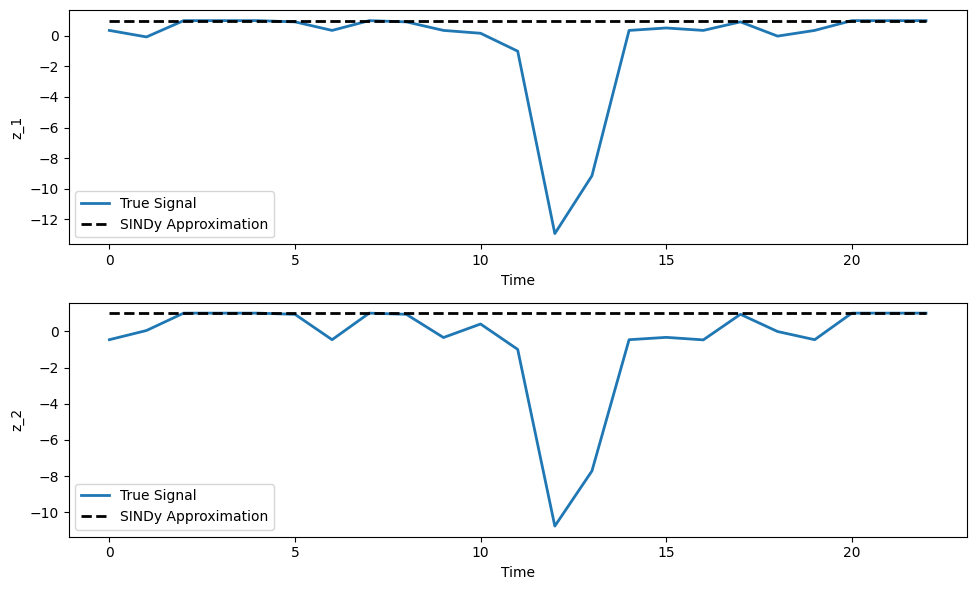

In [ ]:
###############Normalization###############
gru_outs_test_np = gru_outs_test.detach().cpu().numpy()

for i in range(latent_dim):
    print(" GRU OUTS TEST STATS BEFORE NORMALIZATION dim ", i, " min: ", np.min(gru_outs_test_np[:,i]), " max: ", np.max(gru_outs_test_np[:,i]))
    gru_outs_test_np[:, i] = (gru_outs_test_np[:, i] - np.min(gru_outs_numpy[:, i])) / (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i]))

gru_outs_test_np = 2 * gru_outs_test_np - 1  # Transform to [-1, 1]

################Forward simulation with the model################
t_test = np.arange(0, n_test-1) * (  dt_for_sindy)

# init_cond = np.zeros(latent_dim)
# init_cond[:latent_dim] = gru_outs_test_np[0, :]
init_cond = np.zeros(2*latent_dim)
init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
init_cond[latent_dim:] = (differentiation_method._differentiate(gru_outs.detach().cpu().numpy(), dt_for_sindy))[0,:]


x_sim_test = model.simulate(init_cond, t_test)

# Plotting for each latent dimension: True vs SINDy
fig, ax = plt.subplots(latent_dim, figsize=(10, latent_dim * 3))

print(" x_sim_test shape: ", x_sim_test.shape)
print(" gru_outs_test_np shape: ", gru_outs_test_np.shape)

for i in range(latent_dim):
    ax[i].plot(gru_outs_test_np[:, i], label='True Signal', linewidth=2)
    ax[i].plot(x_sim_test[:, i], "k--", label='SINDy Approximation', linewidth=2)
    ax[i].legend()
    ax[i].set_ylabel(f'z_{i+1}')
    ax[i].set_xlabel('Time')

plt.tight_layout()
plt.show()

###############Predict back in the pixel space###############

# Step 1: Revert the normalization to original scale
gru_outs_test_np = (gru_outs_test_np + 1) / 2  # Revert from [-1, 1] to [0, 1]

# for i in range(latent_dim):  # Assuming 3 latent dimensions for this example
#     gru_outs_test_np[:, i] = gru_outs_test_np[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

# Step 2: Decoder reconstruction using the decoder model
latent_pred = torch.FloatTensor(gru_outs_test_np).to(device)

# Pass through the decoder
output = shred.linear1(latent_pred)
# output = shred.dropout(output) # TODO:you shouldnt do dropout at inference!
output = torch.nn.functional.relu(output)
output = shred.linear2(output)
# output = shred.dropout(output)  # TODO:you shouldnt do dropout at inference!
output = torch.nn.functional.relu(output)
output = shred.linear3(output)

output_np = output.detach().cpu().numpy()

In [ ]:
###############Plotting settings###############
load_X = load_X_original_Temp_scale
mean_X = np.mean(load_X, axis=0)
sst_locs = np.where(mean_X != 0)[0]
reconstructed_data = np.zeros_like(load_X[0, :])
reconstructed_data[sst_locs] = output_np[0, :]  # Assuming first timestep
reshaped_reconstructed = reconstructed_data.reshape(nx, ny)

x sim_test after reverting from [-1, 1] to [0, 1]: (23, 4)
 shape of input to decoder (latent_pred_sindy):  torch.Size([23, 2])
output sindy np shape: (23, 10000)


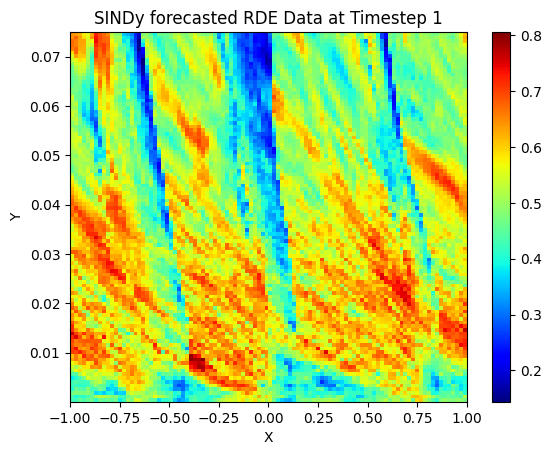

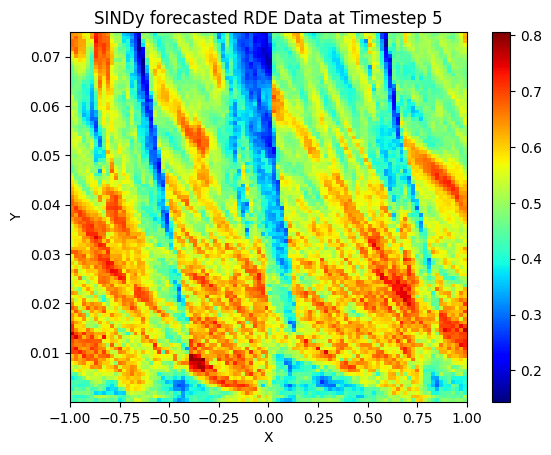

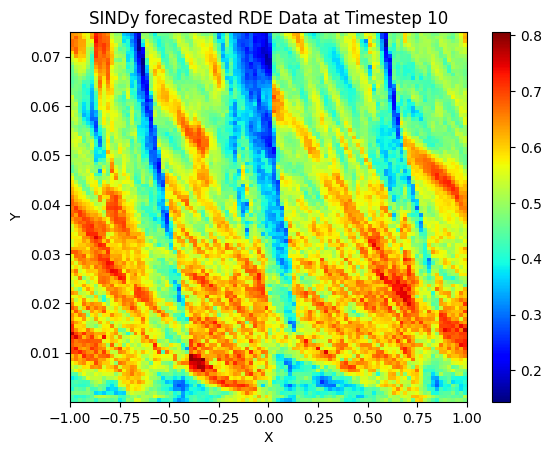

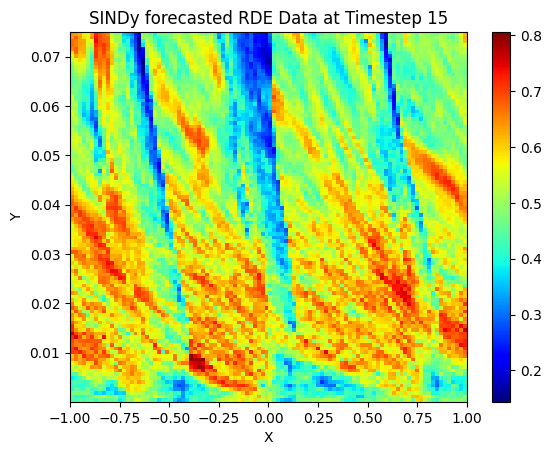

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat

def reconstruct_and_plot_sindy(x_sim_test, gru_outs_numpy, decoder_model, sst_data_path, timesteps):
    """
    Reconstructs and visualizes data using SINDy-simulated latent space for multiple timesteps.

    Args:
        x_sim_test (np.array): SINDy-simulated latent space.
        gru_outs_numpy (np.array): The original latent space for Min-Max scaling reversal.
        decoder_model (nn.Module): The decoder model for reconstruction.
        sst_data_path (str): Path to the SST data file (.npy format).
        timesteps (list of int): List of timesteps to plot.

    Returns:
        output_sindy_np (np.array): The reconstructed SINDy-simulated data.
    """
    # Step 1: Reverse Min-Max scaling for SINDy-simulated data (x_sim_test)
    x_sim_test = np.array(x_sim_test)  # Ensure it's a numpy array if needed
    # Revert the scaling from [-1, 1] back to [0, 1]
    x_sim_test = (x_sim_test + 1) / 2
    print("x sim_test after reverting from [-1, 1] to [0, 1]:", x_sim_test.shape)
    # Perform the Min-Max reverse transformation using the original min/max values
    for i in range(latent_dim):  # Use actual latent_dim instead of hardcoded 3
        x_sim_test[:, i] = x_sim_test[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

    # Perform the decoder reconstruction using the transformed SINDy-simulated data
    latent_pred_sindy = torch.FloatTensor(x_sim_test).to(device)  # Convert to torch tensor for reconstruction

    decoder_input = latent_pred_sindy[:, :latent_dim]
    print(" shape of input to decoder (latent_pred_sindy): ",decoder_input.shape)

    # Pass the SINDy-simulated latent space data through the decoder
    output_sindy = decoder_model.linear1(decoder_input)
    # output_sindy = decoder_model.dropout(output_sindy)
    output_sindy = torch.nn.functional.relu(output_sindy)
    output_sindy = decoder_model.linear2(output_sindy)
    # output_sindy = decoder_model.dropout(output_sindy)
    output_sindy = torch.nn.functional.relu(output_sindy)
    output_sindy = decoder_model.linear3(output_sindy)

    # Detach and convert the reconstructed data back to numpy for visualization
    output_sindy_np = output_sindy.detach().cpu().numpy()
    print("output sindy np shape:", output_sindy_np.shape)
    # Load the data file (supports both .npy and .mat formats)
    if sst_data_path.endswith('.npy'):
        load_X = np.load(sst_data_path).T
    else:
        load_X = loadmat(sst_data_path)['Z'].T
    
    mean_X = np.mean(load_X, axis=0)
    sst_locs = np.where(mean_X != 0)[0]

    # Prepare the SST data reconstruction and plot for each timestep
    for t in timesteps:
        # Use the plotting function from utils
        plot_field_snapshot(
            output_sindy_np.T,
            time_index=t,
            nx=nx,
            ny=ny,
            x=x,
            y=y,
            title=f'SINDy forecasted RDE Data at Timestep {t}',
            cmap="jet",
        )
        plt.show()

        
    return output_sindy_np

# Example usage
timesteps = [1, 5, 10, 15]  # Define timesteps to plot
output_sindy_np = reconstruct_and_plot_sindy(x_sim_test, gru_outs_numpy, shred, '../20Timesteps-second_dataset/pressure_matrix_compressed.npy', timesteps)


In [ ]:
print(" min and max of reconstructed sindy data: ", np.min(output_sindy_np), " , ", np.max(output_sindy_np))

 min and max of reconstructed sindy data:  0.1438405  ,  0.80589503


### Comparing the true data to predictions

In [ ]:
sindy_forecast = sc.inverse_transform(output_sindy_np)
create_field_animation(
        sindy_forecast.T,
        nx=nx,
        ny=ny,
        output_file="temp_field_SINDY_forecast.mp4",
        x=x,
        y=y,
        field_name="Temperature",
        cmap="jet",
        fps=15,
        figsize=(8, 6),
    )
# Also create animation for ground truth for comparison
dataset_to_compare = test_dataset
ground_truth = sc.inverse_transform(dataset_to_compare.Y.detach().cpu().numpy())
create_field_animation(
        ground_truth.T,
        nx=nx,
        ny=ny,
        output_file="temp_field_true_outputs.mp4",
        x=x,
        y=y,
        field_name="Temperature",
        cmap="jet",
        fps=15,
        figsize=(8, 6),
    )
   

Creating animation with 23 frames at 15 fps...
Saving animation to temp_field_SINDY_forecast.mp4...
Animation saved successfully to temp_field_SINDY_forecast.mp4
Creating animation with 24 frames at 15 fps...
Saving animation to temp_field_true_outputs.mp4...
Animation saved successfully to temp_field_SINDY_forecast.mp4
Creating animation with 24 frames at 15 fps...
Saving animation to temp_field_true_outputs.mp4...
Animation saved successfully to temp_field_true_outputs.mp4
Animation saved successfully to temp_field_true_outputs.mp4


 x shape:  (100,)  y shape:  (100,)
 x_coords shape:  (100, 100)  y_coords shape:  (100, 100)
Real data size: 24, SINDy data size: 23
Using timesteps: [5, 11, 17]
Grid dimensions: 100 x 100
SST locations: 10000
Data dimension: 10000


IndexError: index 100 is out of bounds for axis 0 with size 100

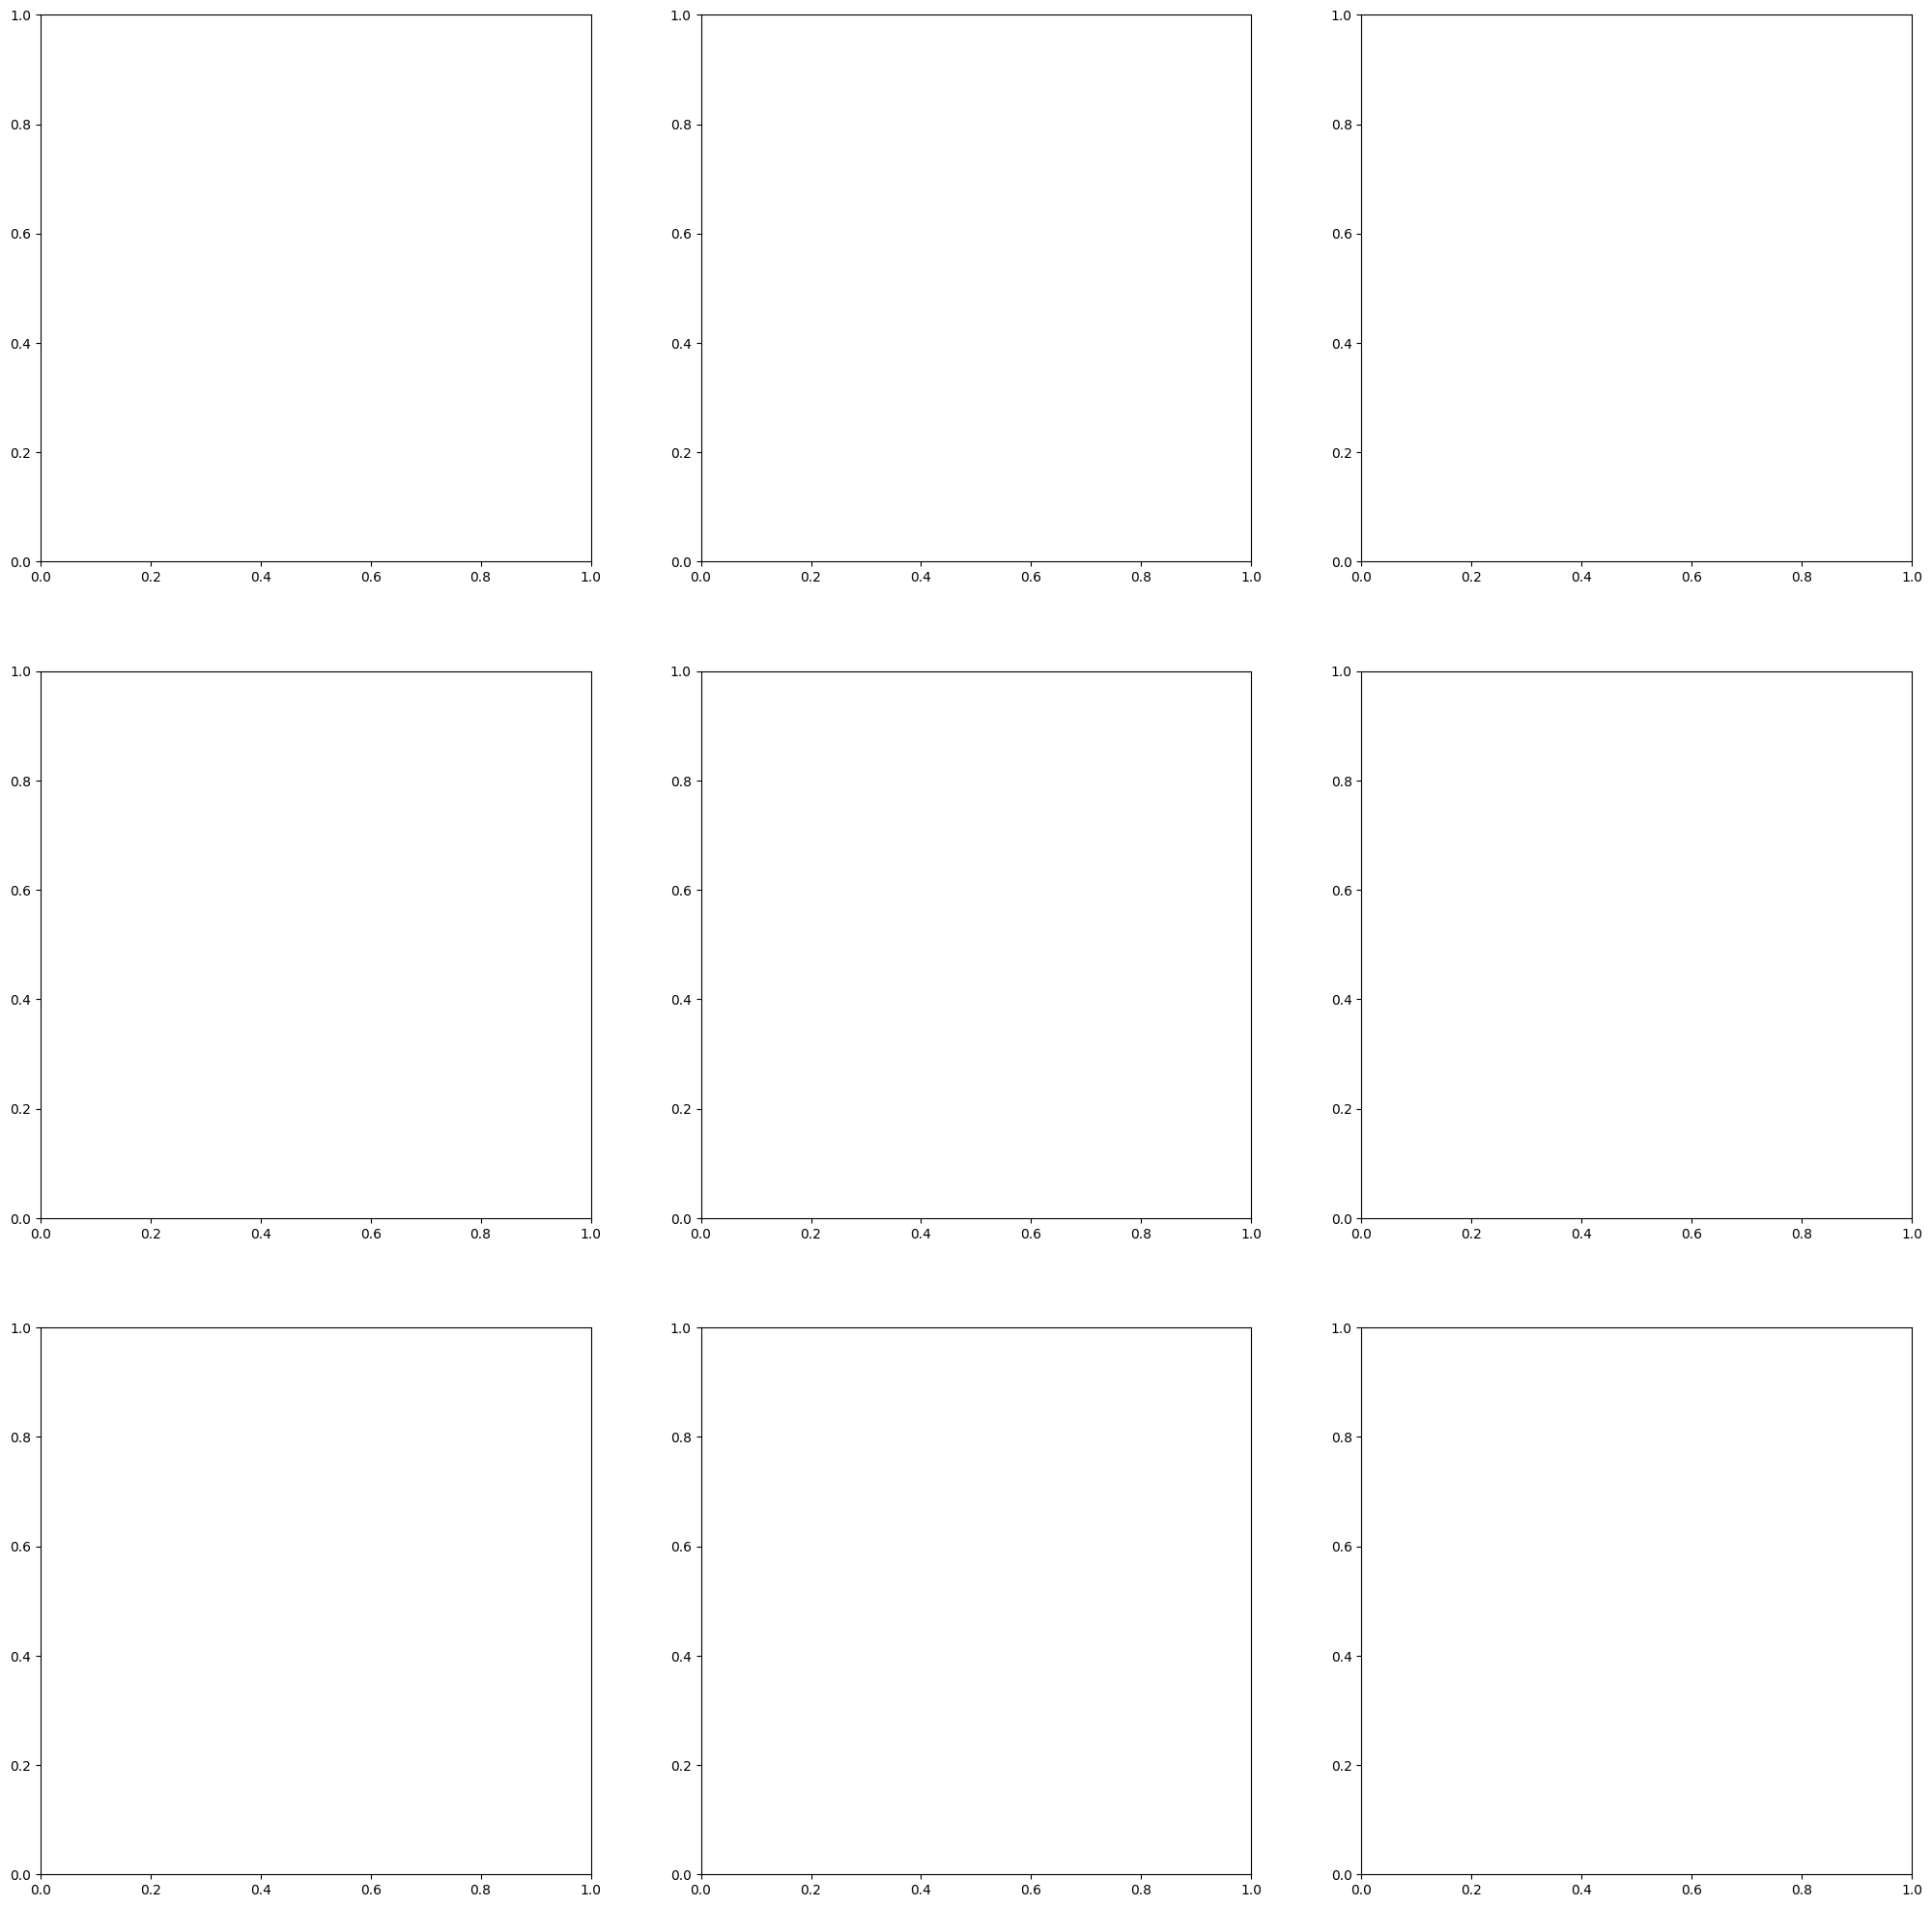

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_zoomed_comparison(real_data, sindy_data, sst_locs, timesteps, xy_grid, diff_scale=10):
    """
    Plot the real SST data, SINDy-SHRED predictions, and their differences using xy_grid coordinates.
    The difference is amplified by a scaling factor to make it clearer.

    Args:
        real_data (np.array): The ground truth SST data.
        sindy_data (np.array): The SINDy-SHRED reconstructed data.
        sst_locs (np.array): Indices of non-zero SST locations.
        timesteps (list of int): List of timesteps to visualize.
        xy_grid (tuple): Pre-loaded xy coordinates (x, y).
        diff_scale (float): Scaling factor for amplifying the difference plot.

    Returns:
        None. Displays the comparison plots.
    """
    x_coords, y_coords = xy_grid
    
    # Ensure timesteps are within bounds
    max_timestep = min(real_data.shape[0], sindy_data.shape[0]) - 1
    valid_timesteps = [t for t in timesteps if t <= max_timestep]
    
    if not valid_timesteps:
        print(f"Warning: No valid timesteps. Real data size: {real_data.shape[0]}, SINDy data size: {sindy_data.shape[0]}")
        print(f"Using timesteps: {[0, max_timestep//3, 2*max_timestep//3, max_timestep]}")
        valid_timesteps = [0, max_timestep//3, 2*max_timestep//3, max_timestep]
    
    # Get unique x and y coordinates to determine grid dimensions
    x_unique = np.unique(x_coords)
    y_unique = np.unique(y_coords)
    grid_nx = len(x_unique)
    grid_ny = len(y_unique)
    
    print(f"Grid dimensions: {grid_nx} x {grid_ny}")
    print(f"SST locations: {len(sst_locs)}")
    print(f"Data dimension: {real_data.shape[1]}")
    
    num_plots = len(valid_timesteps)
    fig, axes = plt.subplots(3, num_plots, figsize=(25, 25))
    
    for i, t in enumerate(valid_timesteps):
        # Initialize full grid with NaN or background value
        real_sst_grid = np.full((grid_ny, grid_nx), -0.25)
        sindy_sst_grid = np.full((grid_ny, grid_nx), -0.25)
        
        # Map SST data to grid using indices
        for idx, sst_idx in enumerate(sst_locs):
            if idx < real_data.shape[1] and idx < sindy_data.shape[1]:
                # Get x, y coordinates for this SST location
                x_coord = x_coords[sst_idx]
                y_coord = y_coords[sst_idx]
                
                # Find grid indices
                x_grid_idx = np.argmin(np.abs(x_unique - x_coord))
                y_grid_idx = np.argmin(np.abs(y_unique - y_coord))
                
                # Assign values
                real_sst_grid[y_grid_idx, x_grid_idx] = real_data[t, idx]
                sindy_sst_grid[y_grid_idx, x_grid_idx] = sindy_data[t, idx]

        # Plot Real Data
        im0 = axes[0, i].imshow(real_sst_grid, aspect='auto', cmap='twilight', interpolation='none', 
                                extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                                origin='lower')
        axes[0, i].set_title(f'Real Data (Timestep {t})')
        axes[0, i].set_xlabel('x')
        axes[0, i].set_ylabel('y')

        # Plot SINDy-SHRED Prediction
        im1 = axes[1, i].imshow(sindy_sst_grid, aspect='auto', cmap='twilight', interpolation='none',
                                extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                                origin='lower')
        axes[1, i].set_title(f'SINDy-SHRED Prediction (Timestep {t})')
        axes[1, i].set_xlabel('x')
        axes[1, i].set_ylabel('y')

        # Plot Difference (Real - SINDy) with scaling factor
        diff_sst = diff_scale * np.square(real_sst_grid - sindy_sst_grid)
        im2 = axes[2, i].imshow(diff_sst, aspect='auto', cmap='plasma', interpolation='none', vmin=-1, vmax=1,
                                extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                                origin='lower')
        axes[2, i].set_title(f'Difference (Timestep {t}) [Scaled]')
        axes[2, i].set_xlabel('x')
        axes[2, i].set_ylabel('y')
    
    # Add colorbars
    fig.colorbar(im0, ax=axes[0, :], orientation='horizontal', pad=0.05, fraction=0.046)
    fig.colorbar(im1, ax=axes[1, :], orientation='horizontal', pad=0.05, fraction=0.046)
    fig.colorbar(im2, ax=axes[2, :], orientation='horizontal', pad=0.05, fraction=0.046)

    # Adjust layout
    plt.tight_layout()
    plt.show()


x = phi_axis
y = h_axis
# generate a grid with these x and y values
x_coords, y_coords = np.meshgrid(x, y)
print(" x shape: ", x.shape, " y shape: ", y.shape)
print(" x_coords shape: ", x_coords.shape, " y_coords shape: ", y_coords.shape)
xy_grid_coords = (x_coords, y_coords)  # Use existing variables

real_data_size = test_dataset.Y.detach().cpu().numpy().shape[0]
sindy_data_size = output_sindy_np.shape[0]
min_size = min(real_data_size, sindy_data_size)

# Automatically select representative timesteps based on data size
timesteps = [int(i * min_size / 4) for i in range(1, 4)]  # Quarter, half, three-quarters
print(f"Real data size: {real_data_size}, SINDy data size: {sindy_data_size}")
print(f"Using timesteps: {timesteps}")

ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
sindy_forecast = sc.inverse_transform(output_sindy_np)

plot_zoomed_comparison(ground_truth, sindy_forecast, sst_locs, 
                       timesteps, xy_grid_coords, diff_scale=10)

# fix the above first


Loaded xy_grid from RDE dataset: x shape=(65536,), y shape=(65536,)
Grid dimensions: 512 x 128
Output reconstructed shape: (2, 65536)
X coordinates shape: (65536,)
Y coordinates shape: (65536,)


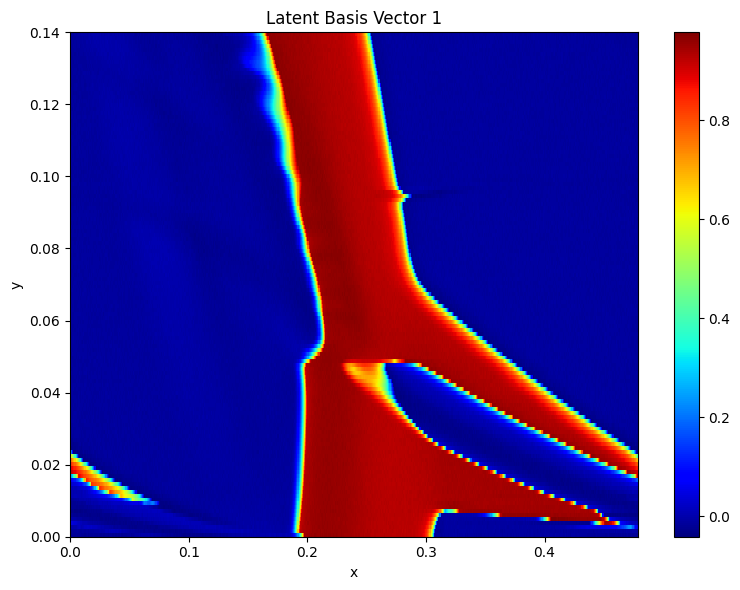

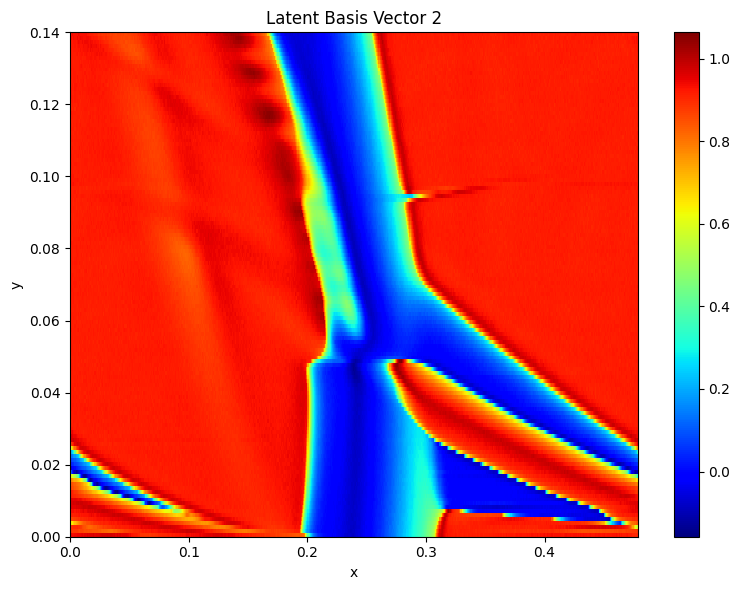

In [ ]:
def plot_rescaled_latent_reconstructions(decoder_model, gru_outs_numpy, xy_grid=None, grid_dims=None):
    """
    Rescales and plots the decoder reconstruction for specific latent space vectors (1,0,0), (0,1,0), and (0,0,1).
    Uses the actual RDE grid dimensions and xy coordinates for proper visualization.

    Args:
        decoder_model (nn.Module): The decoder model for reconstruction.
        gru_outs_numpy (np.array): Original latent space data for Min-Max scaling reversal.
        xy_grid (tuple): Pre-loaded xy coordinates (x, y).
        grid_dims (tuple): Grid dimensions (nx, ny).

    Returns:
        None. Displays the plots.
    """
    # Define the specific latent space vectors
    latent_vectors = np.eye(latent_dim)  # (1,0,0), (0,1,0), (0,0,1)
    # Convert latent vectors to a torch tensor
    latent_vectors_tensor = torch.FloatTensor(latent_vectors).to(device)

    for i in range(latent_dim):  # Assuming latent_dim latent dimensions
        latent_vectors_tensor[:, i] = latent_vectors_tensor[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

    # Perform reconstruction using the decoder
    output_reconstructed = decoder_model.linear1(latent_vectors_tensor)
    # Don't use dropout at inference time
    output_reconstructed = torch.nn.functional.relu(output_reconstructed)
    output_reconstructed = decoder_model.linear2(output_reconstructed)
    output_reconstructed = torch.nn.functional.relu(output_reconstructed)
    output_reconstructed = decoder_model.linear3(output_reconstructed)

    # Convert reconstructed data back to numpy
    output_reconstructed_np = output_reconstructed.detach().cpu().numpy()
    
    # Use provided grid dimensions or defaults
    if grid_dims is None:
        grid_dims = (nx, ny)
    grid_nx, grid_ny = grid_dims
    
    # Get xy coordinates
    if xy_grid is None:
        x_coords, y_coords = x, y  # Use globally loaded x, y
    else:
        x_coords, y_coords = xy_grid

    print(f"Grid dimensions: {grid_nx} x {grid_ny}")
    print(f"Output reconstructed shape: {output_reconstructed_np.shape}")
    print(f"X coordinates shape: {x_coords.shape if hasattr(x_coords, 'shape') else 'N/A'}")
    print(f"Y coordinates shape: {y_coords.shape if hasattr(y_coords, 'shape') else 'N/A'}")

    # Get unique x and y coordinates to determine grid dimensions for plotting
    x_unique = np.unique(x_coords)
    y_unique = np.unique(y_coords)
    plot_grid_nx = len(x_unique)
    plot_grid_ny = len(y_unique)
    
    # Plot each reconstructed result using the sparse grid mapping
    for i, vec in enumerate(latent_vectors):
        try:
            # Initialize full grid with background value
            field_grid = np.full((plot_grid_ny, plot_grid_nx), -0.25)
            
            # Map decoder output to grid using sst_locs indices and xy_grid
            for idx, sst_idx in enumerate(sst_locs):
                if idx < output_reconstructed_np.shape[1]:
                    # Get x, y coordinates for this location
                    x_coord = x_coords[sst_idx]
                    y_coord = y_coords[sst_idx]
                    
                    # Find grid indices
                    x_grid_idx = np.argmin(np.abs(x_unique - x_coord))
                    y_grid_idx = np.argmin(np.abs(y_unique - y_coord))
                    
                    # Assign value
                    field_grid[y_grid_idx, x_grid_idx] = output_reconstructed_np[i, idx]
            
            # Use the utility function to plot with proper coordinates
            fig, ax = plt.subplots(figsize=(8, 6))
            im = ax.imshow(field_grid, aspect='auto', cmap='jet', interpolation='none',
                          extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                          origin='lower')
            ax.set_title(f'Latent Basis Vector {i+1}')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            plt.colorbar(im, ax=ax)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error plotting basis vector {i+1}: {e}")
            print(f"Traceback: {type(e).__name__}")

# Load xy_grid from the RDE dataset directory
grid_file_path = "../20Timesteps-second_dataset/grid_xy.npy"
if os.path.exists(grid_file_path):
    xy_grid_loaded = np.load(grid_file_path)
    if xy_grid_loaded.shape[0] == 2:
        xy_grid_for_basis = (xy_grid_loaded[0], xy_grid_loaded[1])
    else:
        xy_grid_for_basis = (x, y)
    print(f"Loaded xy_grid from RDE dataset: x shape={xy_grid_for_basis[0].shape}, y shape={xy_grid_for_basis[1].shape}")
else:
    print("Warning: xy_grid file not found, will use default grid")
    xy_grid_for_basis = (x, y)

# Plot the rescaled latent reconstructions
plot_rescaled_latent_reconstructions(
    decoder_model=shred,
    gru_outs_numpy=gru_outs_numpy,
    xy_grid=xy_grid_for_basis,
    grid_dims=(nx, ny)
)

Using timesteps: [0, 12, 24, 36]
Grid dimensions: 512 x 128
SST locations: 65536
Data dimension: 65536


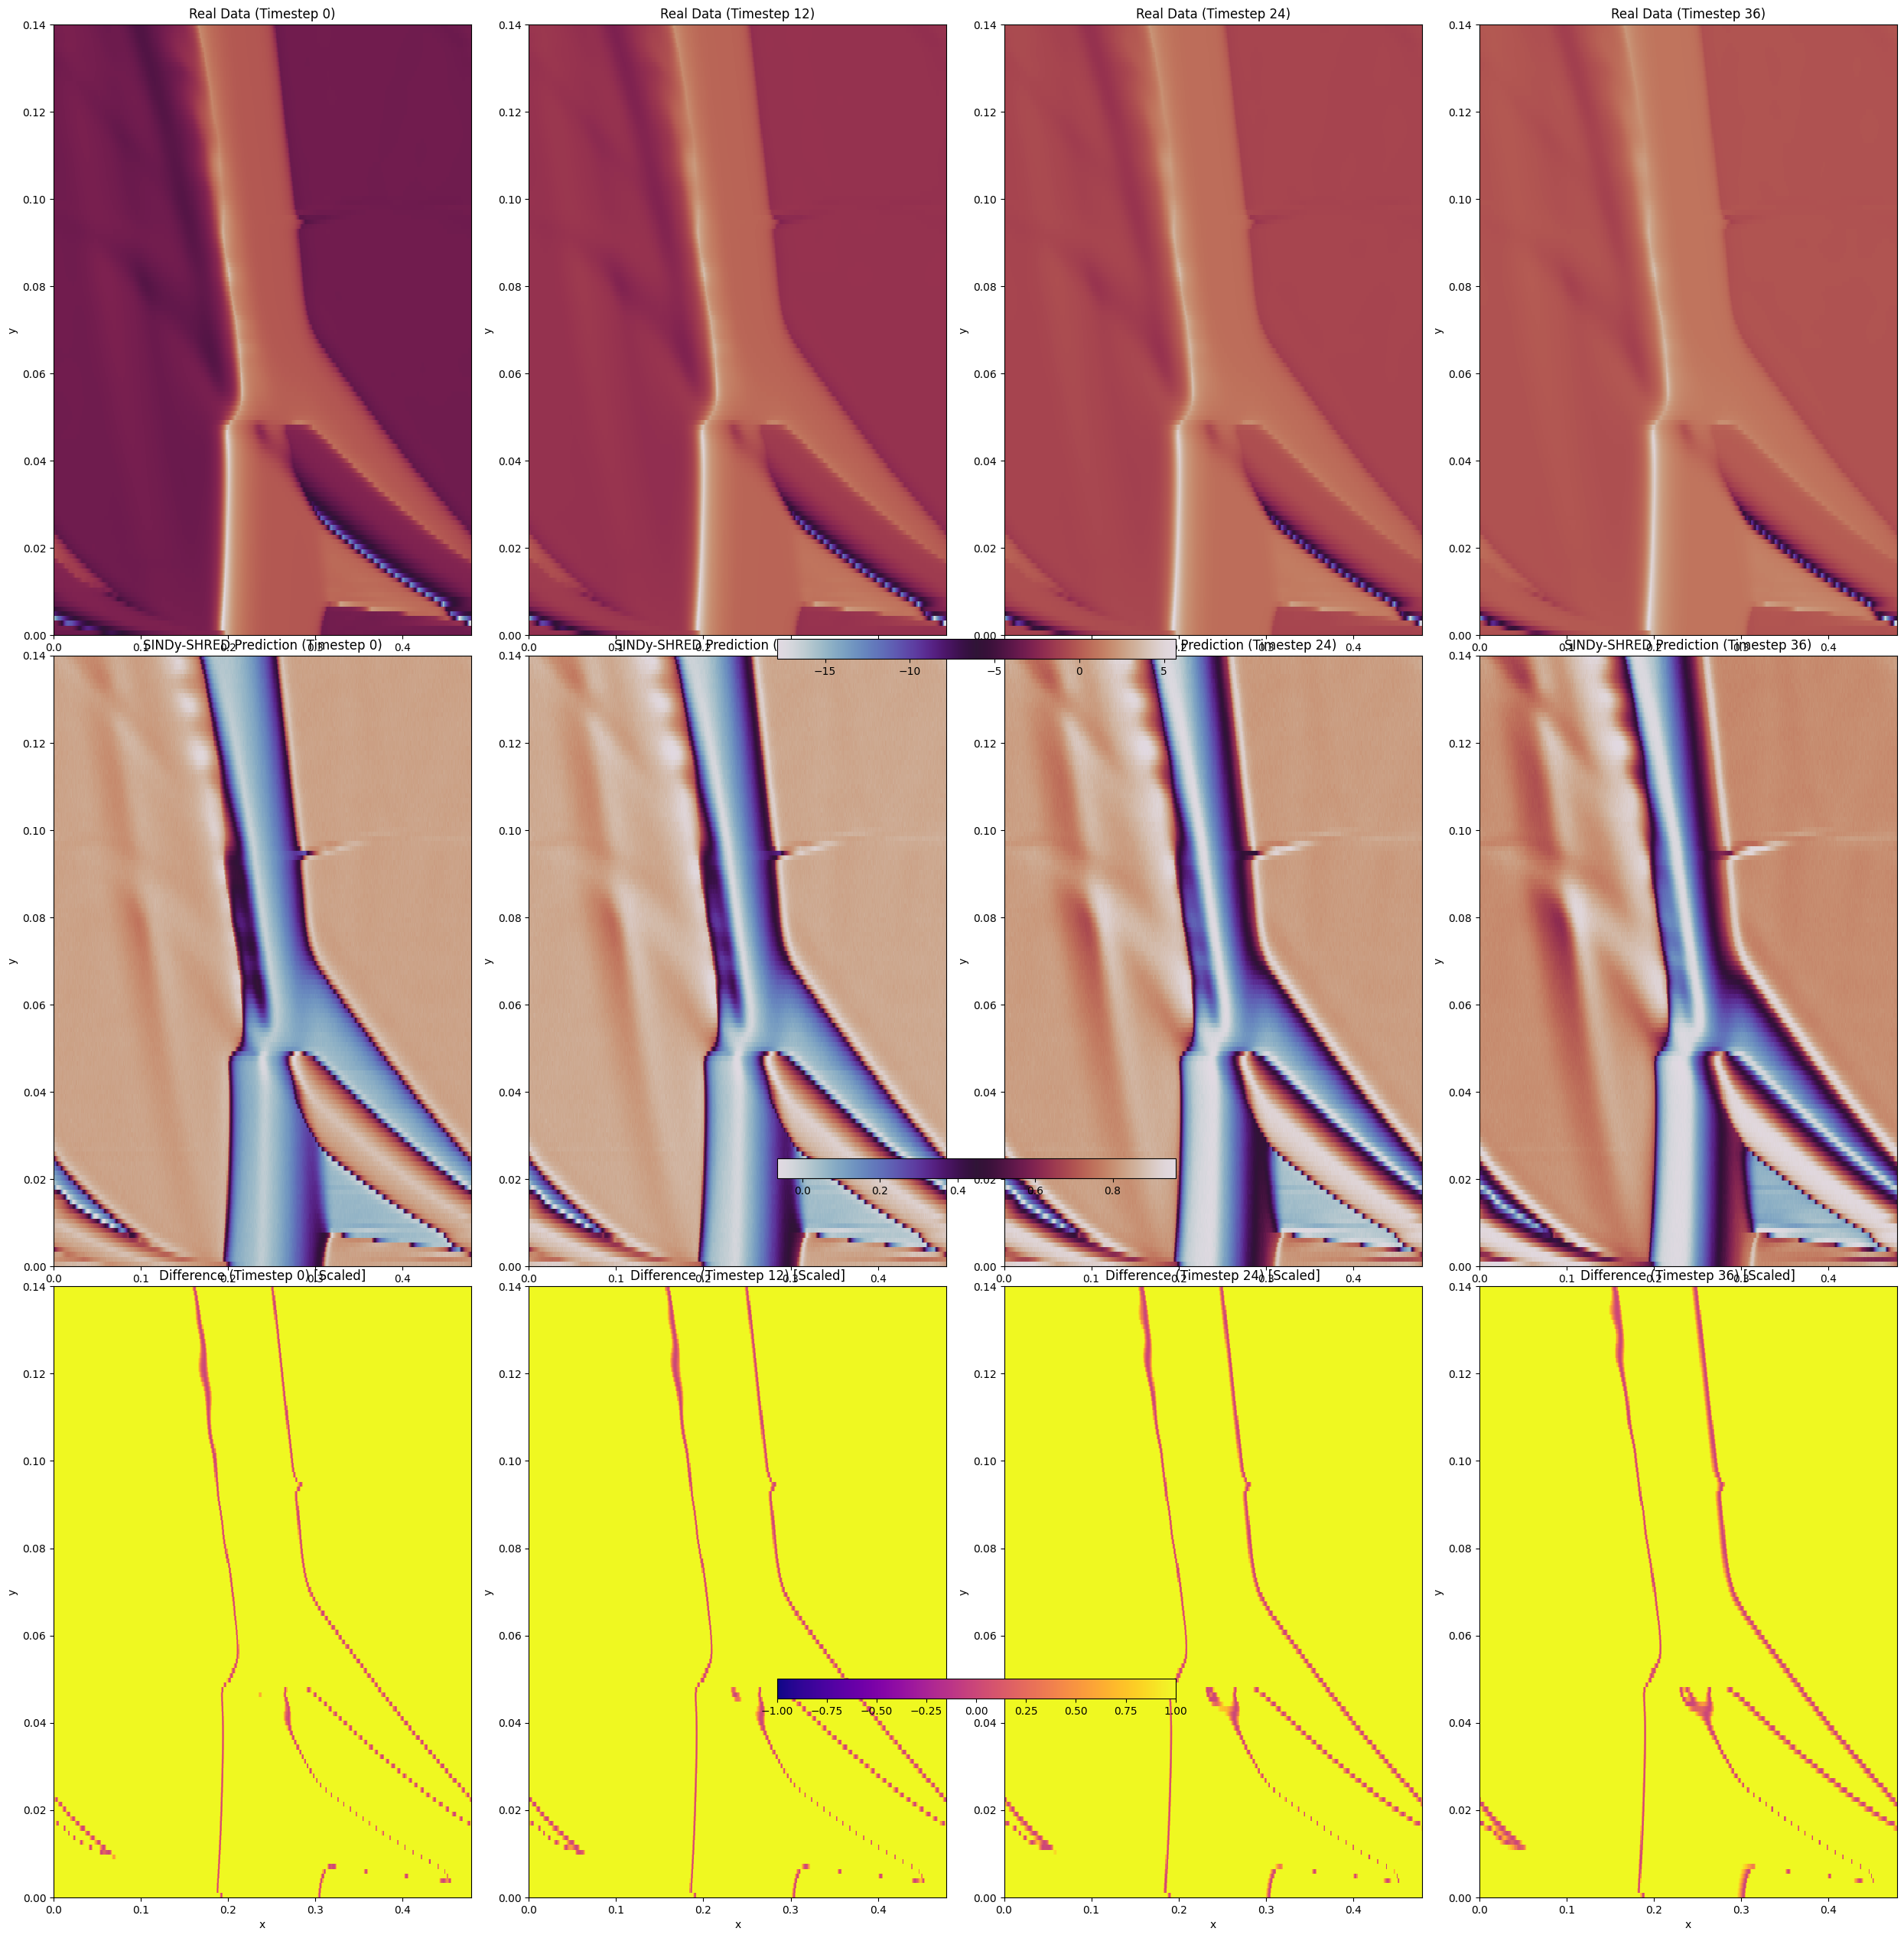

In [ ]:
# Example usage:
timesteps = [50, 100, 150]  # Define the timesteps you want to compare
plot_zoomed_comparison(test_dataset.Y.detach().cpu().numpy(), output_sindy_np, sst_locs, timesteps, xy_grid_coords, diff_scale=10)

### Sensor-level plots

Test dataset shape: torch.Size([38, 65536])
Output SINDy shape: (37, 65536)
Number of sensors to plot: 18


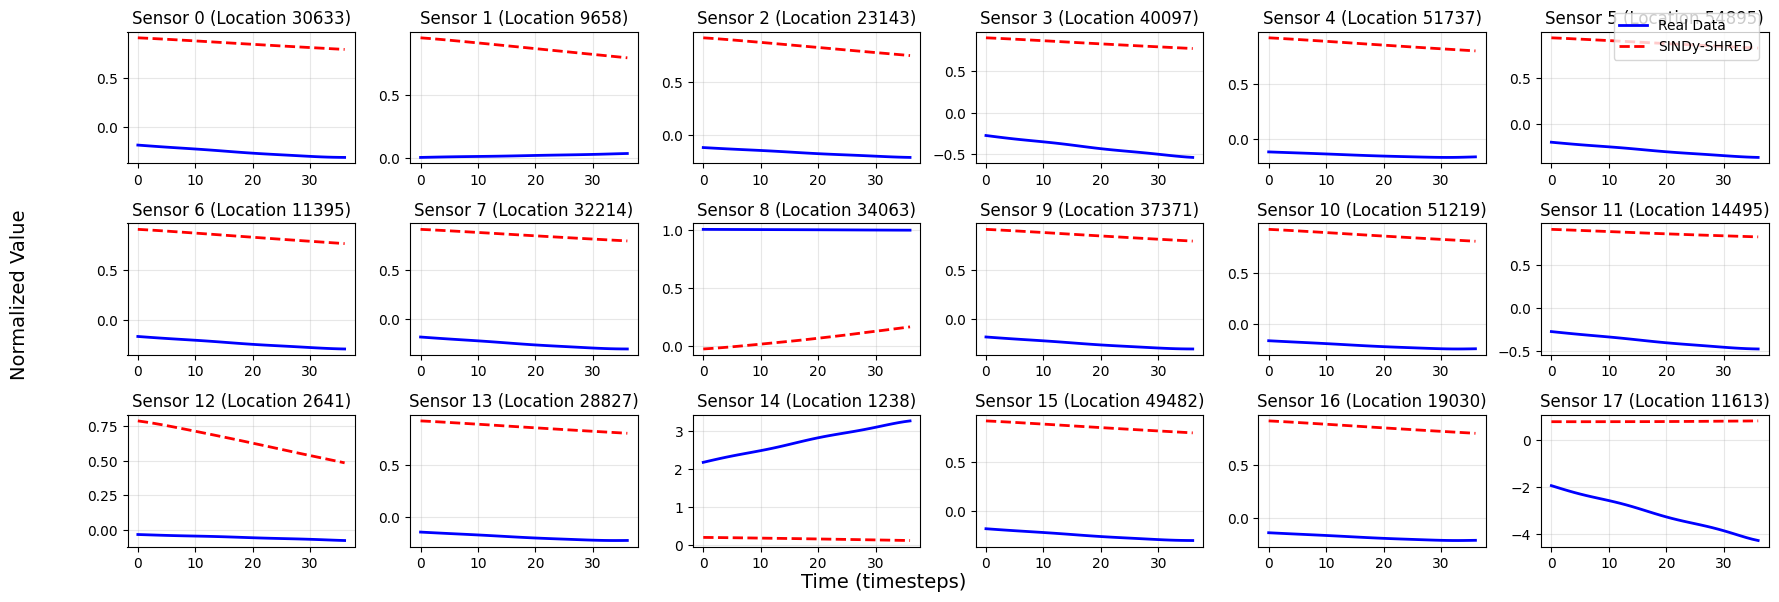

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_sensor_predictions(real_data, sindy_data, sensor_locations, sensor_indices, 
                                     num_train=None, num_pred=None, rows=4, cols=4):
    """
    Plot the real data and SINDy-SHRED prediction for multiple sensors in a grid layout.

    Args:
        real_data (np.array): The real test data (timesteps x spatial dimensions).
        sindy_data (np.array): The predicted data from SINDy-SHRED (timesteps x spatial dimensions).
        sensor_locations (np.array): Sensor locations (indices) used in training.
        sensor_indices (list): Indices into sensor_locations array to visualize (e.g., [0, 1, 2, ...]).
        num_train (int or None): Number of training timesteps. Used to draw vertical line only.
        num_pred (int or None): Number of prediction timesteps. If None, uses sindy_data size.
        rows (int): Number of rows in the grid layout.
        cols (int): Number of columns in the grid layout.

    Returns:
        None. Displays and saves the plot.
    """
    # Get actual data sizes
    real_data_timesteps = real_data.shape[0]
    sindy_data_timesteps = sindy_data.shape[0]
    
    # Handle defaults for num_pred
    if num_pred is None:
        num_pred = sindy_data_timesteps
    
    # Limit to available data
    num_pred = min(num_pred, sindy_data_timesteps, real_data_timesteps)
    
    # If num_train is not specified, don't draw the split line
    draw_split_line = num_train is not None
    
    num_sensors = len(sensor_indices)
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 2*rows), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

    for i, sensor_idx in enumerate(sensor_indices):
        if i >= rows * cols:
            break  # Stop if we've exceeded the number of subplots
        
        # Get the actual sensor location index
        if sensor_idx >= len(sensor_locations):
            print(f"Warning: sensor_idx {sensor_idx} exceeds sensor_locations length {len(sensor_locations)}")
            continue
        
        sensor_location = sensor_locations[sensor_idx]

        # Extract time series for this sensor from real data
        # Real data shape is (timesteps, spatial_points)
        if sensor_location < real_data.shape[1]:
            sensor_real_data = real_data[:num_pred, sensor_location]
        else:
            print(f"Warning: sensor_location {sensor_location} exceeds real_data dimension {real_data.shape[1]}")
            continue

        # Extract time series for this sensor from SINDy predictions
        # sindy_data contains predictions (timesteps x spatial_points)
        if sensor_location < sindy_data.shape[1]:
            sensor_pred_data = sindy_data[:num_pred, sensor_location]
        else:
            print(f"Warning: sensor_location {sensor_location} exceeds sindy_data dimension {sindy_data.shape[1]}")
            continue

        # Plot real data
        axes[i].plot(np.arange(len(sensor_real_data)), sensor_real_data, color="blue", linewidth=2, label="Real Data")
        
        # Plot predictions
        axes[i].plot(np.arange(len(sensor_pred_data)), sensor_pred_data, color="red", linestyle="--", linewidth=2, label="SINDy-SHRED")

        axes[i].set_title(f'Sensor {sensor_idx} (Location {sensor_location})', fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=10)
        axes[i].grid(True, alpha=0.3)

        # Add a vertical line to separate training and prediction periods if num_train is provided
        if draw_split_line and num_train is not None and num_train < len(sensor_real_data):
            axes[i].axvline(x=num_train, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)

    # Remove any unused subplots
    for i in range(num_sensors, rows * cols):
        fig.delaxes(axes[i])

    # Add labels and legend
    fig.text(0.5, 0.02, 'Time (timesteps)', ha='center', va='center', fontsize=14)
    fig.text(0.02, 0.5, 'Normalized Value', ha='center', va='center', rotation='vertical', fontsize=14)
    
    # Add a common legend
    lines = [plt.Line2D([0], [0], color="blue", lw=2),
             plt.Line2D([0], [0], color="red", linestyle="--", lw=2)]
    labels = ["Real Data", "SINDy-SHRED"]
    fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.99, 0.98), fontsize=10, frameon=True)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08, left=0.08)
    plt.savefig('sensor_predictions_grid.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Example usage with actual RDE data and training sensor locations
# Use the sensor_locations from the training phase and select some to visualize
n_sensors_to_plot = min(18, len(sensor_locations))
sensor_indices_to_plot = list(range(0, n_sensors_to_plot))

print(f"Test dataset shape: {test_dataset.Y.shape}")
print(f"Output SINDy shape: {output_sindy_np.shape}")
print(f"Number of sensors to plot: {n_sensors_to_plot}")

plot_multiple_sensor_predictions(
    test_dataset.Y.detach().cpu().numpy(), 
    output_sindy_np, 
    sensor_locations,  # Use actual sensor locations from training
    sensor_indices_to_plot,
    num_train=None,  # Don't highlight train/test split since we're only showing test data
    num_pred=None,  # Use all available prediction data
    rows=3, 
    cols=6
)